In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2
import os
import matplotlib.pyplot as plt

---
# 1-Prepare Data
---



## Download Data

In [ ]:
#!git clone https://github.com/iiscleap/Coswara-Data.git

Cloning into 'Coswara-Data'...
remote: Enumerating objects: 559, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (30/30), done.


In [ ]:
'''
rt_dir = '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data'
import glob
import os
for each in os.listdir(rt_dir):
    if os.path.isdir(os.path.join(rt_dir,each)) and each != '.git':
        print(each)
        !cat {os.path.join(rt_dir, each,'')}*.tar.gz.* > {os.path.join(rt_dir, each,'')}combined_file.tar.gz
        !tar -xzf {os.path.join(rt_dir, each,'')}combined_file.tar.gz -C {rt_dir}
subset = glob.glob('/content/Coswara-Data/*/*.tar.gz.*') + glob.glob('/content/Coswara-Data/*/combined_data.tar.gz')
[os.remove(x) for x in subset];
'''

In [3]:
'''
!wget https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
!mv public_dataset.zip?download=1 public_dataset.zip
!unzip -q public_dataset.zip
!mkdir 'custom_dataset'
'''

--2021-05-03 21:56:35--  https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77, 192.65.187.5, 192.91.245.85, ...
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 951442487 (907M) [application/octet-stream]
Saving to: ‘public_dataset.zip?download=1’

public_dataset.zip? 100%[===================>] 907.37M  5.63MB/s    in 2m 43s  

2021-05-03 21:59:24 (5.57 MB/s) - ‘public_dataset.zip?download=1’ saved [951442487/951442487]



In [2]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR','DataSet']
join_by = pd.read_csv('/home/sumukhmlohit/my_project_dir/virufy-covid/cough//Coswara-Data/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/*/*/cough-shallow.wav')):
      temp = pd.DataFrame(columns=['id','DIR'])
      temp['id'] = [path.split('/')[-2]]
      temp['DIR'] = [path]
      temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

      temp['fomp']= (temp['fever']| temp['mp']).apply(int)
      temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
      temp        = temp[['id','covid_status','DIR','fomp','oths']]
      df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR','fomp':'Fever/MP','oths':'ORC'}))
CosData1=pd.concat(df_list)
CosData1['DataSet'] = 'coswara'
CosData1.head()

100%|██████████| 1643/1643 [00:27<00:00, 60.43it/s]


ID                   STATUS  \
0  Tvdak0zflIVWdvWsNj7l9Ur0k3m1            positive_mild   
0  nCejocB61DU95Gz2gEcPeH0N2pm1  no_resp_illness_exposed   
0  Cd7fkliPM2ZUM1skytvoU2vD8jK2           positive_asymp   
0  yZtohTVxlSauCUNuIIEUcdIA2TJ3                  healthy   
0  oeOuvTlUMEfWPcNOA4EnTk5Bh4K2                  healthy   

                                                 DIR  Fever/MP  ORC  DataSet  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0  coswara  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    1  coswara  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0  coswara  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0  coswara  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0  coswara

In [3]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR_SPEECH','DataSet']
join_by = pd.read_csv('/home/sumukhmlohit/my_project_dir/virufy-covid/cough//Coswara-Data/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/*/*/counting-fast.wav')):
      temp = pd.DataFrame(columns=['id','DIR_SPEECH'])
      temp['id'] = [path.split('/')[-2]]
      temp['DIR_SPEECH'] = [path]
      temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

      temp['fomp']= (temp['fever']| temp['mp']).apply(int)
      temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
      temp        = temp[['id','covid_status','DIR_SPEECH','fomp','oths']]
      df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR_SPEECH':'DIR_SPEECH','fomp':'Fever/MP','oths':'ORC'}))
CosData2=pd.concat(df_list)
CosData2['DataSet'] = 'coswara'
CosData2.head()

100%|██████████| 1645/1645 [00:29<00:00, 56.39it/s]


ID                   STATUS  \
0  Tvdak0zflIVWdvWsNj7l9Ur0k3m1            positive_mild   
0  nCejocB61DU95Gz2gEcPeH0N2pm1  no_resp_illness_exposed   
0  Cd7fkliPM2ZUM1skytvoU2vD8jK2           positive_asymp   
0  yZtohTVxlSauCUNuIIEUcdIA2TJ3                  healthy   
0  oeOuvTlUMEfWPcNOA4EnTk5Bh4K2                  healthy   

                                          DIR_SPEECH  Fever/MP  ORC  DataSet  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0  coswara  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    1  coswara  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0  coswara  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0  coswara  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0  coswara

In [4]:
CosData2.head()

ID                   STATUS  \
0  Tvdak0zflIVWdvWsNj7l9Ur0k3m1            positive_mild   
0  nCejocB61DU95Gz2gEcPeH0N2pm1  no_resp_illness_exposed   
0  Cd7fkliPM2ZUM1skytvoU2vD8jK2           positive_asymp   
0  yZtohTVxlSauCUNuIIEUcdIA2TJ3                  healthy   
0  oeOuvTlUMEfWPcNOA4EnTk5Bh4K2                  healthy   

                                          DIR_SPEECH  Fever/MP  ORC  DataSet  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0  coswara  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    1  coswara  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0  coswara  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0  coswara  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0  coswara

In [4]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR_SPEECH','DataSet']
join_by = pd.read_csv('/home/sumukhmlohit/my_project_dir/virufy-covid/cough//Coswara-Data/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/*/*/breathing-shallow.wav')):
      temp = pd.DataFrame(columns=['id','DIR_BREATH'])
      temp['id'] = [path.split('/')[-2]]
      temp['DIR_BREATH'] = [path]
      temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

      temp['fomp']= (temp['fever']| temp['mp']).apply(int)
      temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
      temp        = temp[['id','covid_status','DIR_BREATH','fomp','oths']]
      df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR_BREATH':'DIR_BREATH','fomp':'Fever/MP','oths':'ORC'}))
CosData3=pd.concat(df_list)
CosData3['DataSet'] = 'coswara'
CosData3.head()

100%|██████████| 1645/1645 [00:29<00:00, 56.58it/s]


ID                   STATUS  \
0  Tvdak0zflIVWdvWsNj7l9Ur0k3m1            positive_mild   
0  nCejocB61DU95Gz2gEcPeH0N2pm1  no_resp_illness_exposed   
0  Cd7fkliPM2ZUM1skytvoU2vD8jK2           positive_asymp   
0  yZtohTVxlSauCUNuIIEUcdIA2TJ3                  healthy   
0  oeOuvTlUMEfWPcNOA4EnTk5Bh4K2                  healthy   

                                          DIR_BREATH  Fever/MP  ORC  DataSet  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0  coswara  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    1  coswara  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0  coswara  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0  coswara  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0  coswara

In [12]:
CosData1

ID                   STATUS  \
0     Tvdak0zflIVWdvWsNj7l9Ur0k3m1            positive_mild   
1     nCejocB61DU95Gz2gEcPeH0N2pm1  no_resp_illness_exposed   
2     Cd7fkliPM2ZUM1skytvoU2vD8jK2           positive_asymp   
3     yZtohTVxlSauCUNuIIEUcdIA2TJ3                  healthy   
4     oeOuvTlUMEfWPcNOA4EnTk5Bh4K2                  healthy   
...                            ...                      ...   
1638  vn3xkK3lIdViBCa9kMj8LDOy9yV2                  healthy   
1639  hLVaY0Dox1bLCTAqoq0wKKOqBjc2            positive_mild   
1640  YqPKZEEwQ6N51vs5ztJn2a1nVBN2  no_resp_illness_exposed   
1641  IFMid2LmeCTSQAFaL8wTSUg20No2            positive_mild   
1642  56HPUhHPM9UEksAVgCDbQZcxsuZ2            positive_mild   

                                                    DIR  Fever/MP  ORC  \
0     /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   
1     /home/sumukhmlohit/my_project_dir/virufy-covid...         0    1   
2     /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   
3     /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   
4     /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   
...                                                 ...       ...  ...   
1638  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    1   
1639  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    1   
1640  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   
1641  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   
1642  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   

      DataSet  
0     coswara  
1     coswara  
2     coswara  
3     coswara  
4     coswara  
...       ...  
1638  coswara  
1639  coswara  
1640  coswara  
1641  coswara  
1642  coswara  

[1643 rows x 6 columns]

In [28]:
CosData12=pd.merge(CosData1,CosData2,on='ID')

In [29]:
CosData12

ID                 STATUS_x  \
0     Tvdak0zflIVWdvWsNj7l9Ur0k3m1            positive_mild   
1     nCejocB61DU95Gz2gEcPeH0N2pm1  no_resp_illness_exposed   
2     Cd7fkliPM2ZUM1skytvoU2vD8jK2           positive_asymp   
3     yZtohTVxlSauCUNuIIEUcdIA2TJ3                  healthy   
4     oeOuvTlUMEfWPcNOA4EnTk5Bh4K2                  healthy   
...                            ...                      ...   
1638  vn3xkK3lIdViBCa9kMj8LDOy9yV2                  healthy   
1639  hLVaY0Dox1bLCTAqoq0wKKOqBjc2            positive_mild   
1640  YqPKZEEwQ6N51vs5ztJn2a1nVBN2  no_resp_illness_exposed   
1641  IFMid2LmeCTSQAFaL8wTSUg20No2            positive_mild   
1642  56HPUhHPM9UEksAVgCDbQZcxsuZ2            positive_mild   

                                                    DIR  Fever/MP_x  ORC_x  \
0     /home/sumukhmlohit/my_project_dir/virufy-covid...           0      0   
1     /home/sumukhmlohit/my_project_dir/virufy-covid...           0      1   
2     /home/sumukhmlohit/my_project_dir/virufy-covid...           0      0   
3     /home/sumukhmlohit/my_project_dir/virufy-covid...           0      0   
4     /home/sumukhmlohit/my_project_dir/virufy-covid...           0      0   
...                                                 ...         ...    ...   
1638  /home/sumukhmlohit/my_project_dir/virufy-covid...           0      1   
1639  /home/sumukhmlohit/my_project_dir/virufy-covid...           0      1   
1640  /home/sumukhmlohit/my_project_dir/virufy-covid...           0      0   
1641  /home/sumukhmlohit/my_project_dir/virufy-covid...           0      0   
1642  /home/sumukhmlohit/my_project_dir/virufy-covid...           0      0   

     DataSet_x                 STATUS_y  \
0      coswara            positive_mild   
1      coswara  no_resp_illness_exposed   
2      coswara           positive_asymp   
3      coswara                  healthy   
4      coswara                  healthy   
...        ...                      ...   
1638   coswara                  healthy   
1639   coswara            positive_mild   
1640   coswara  no_resp_illness_exposed   
1641   coswara            positive_mild   
1642   coswara            positive_mild   

                                             DIR_SPEECH  Fever/MP_y  ORC_y  \
0     /home/sumukhmlohit/my_project_dir/virufy-covid...           0      0   
1     /home/sumukhmlohit/my_project_dir/virufy-covid...           0      1   
2     /home/sumukhmlohit/my_project_dir/virufy-covid...           0      0   
3     /home/sumukhmlohit/my_project_dir/virufy-covid...           0      0   
4     /home/sumukhmlohit/my_project_dir/virufy-covid...           0      0   
...                                                 ...         ...    ...   
1638  /home/sumukhmlohit/my_project_dir/virufy-covid...           0      1   
1639  /home/sumukhmlohit/my_project_dir/virufy-covid...           0      1   
1640  /home/sumukhmlohit/my_project_dir/virufy-covid...           0      0   
1641  /home/sumukhmlohit/my_project_dir/virufy-covid...           0      0   
1642  /home/sumukhmlohit/my_project_dir/virufy-covid...           0      0   

     DataSet_y  
0      coswara  
1      coswara  
2      coswara  
3      coswara  
4      coswara  
...        ...  
1638   coswara  
1639   coswara  
1640   coswara  
1641   coswara  
1642   coswara  

[1643 rows x 11 columns]

In [30]:
CosData23=pd.merge(CosData2,CosData3,on='ID')

In [32]:
CosData23['DIR_BREATH']

0       /home/sumukhmlohit/my_project_dir/virufy-covid...
1       /home/sumukhmlohit/my_project_dir/virufy-covid...
2       /home/sumukhmlohit/my_project_dir/virufy-covid...
3       /home/sumukhmlohit/my_project_dir/virufy-covid...
4       /home/sumukhmlohit/my_project_dir/virufy-covid...
                              ...                        
1640    /home/sumukhmlohit/my_project_dir/virufy-covid...
1641    /home/sumukhmlohit/my_project_dir/virufy-covid...
1642    /home/sumukhmlohit/my_project_dir/virufy-covid...
1643    /home/sumukhmlohit/my_project_dir/virufy-covid...
1644    /home/sumukhmlohit/my_project_dir/virufy-covid...
Name: DIR_BREATH, Length: 1645, dtype: object

In [44]:
CosData123=pd.merge(CosData12,CosData23,on='ID')

In [45]:
CosData123

ID               STATUS_x_x  \
0     Tvdak0zflIVWdvWsNj7l9Ur0k3m1            positive_mild   
1     nCejocB61DU95Gz2gEcPeH0N2pm1  no_resp_illness_exposed   
2     Cd7fkliPM2ZUM1skytvoU2vD8jK2           positive_asymp   
3     yZtohTVxlSauCUNuIIEUcdIA2TJ3                  healthy   
4     oeOuvTlUMEfWPcNOA4EnTk5Bh4K2                  healthy   
...                            ...                      ...   
1638  vn3xkK3lIdViBCa9kMj8LDOy9yV2                  healthy   
1639  hLVaY0Dox1bLCTAqoq0wKKOqBjc2            positive_mild   
1640  YqPKZEEwQ6N51vs5ztJn2a1nVBN2  no_resp_illness_exposed   
1641  IFMid2LmeCTSQAFaL8wTSUg20No2            positive_mild   
1642  56HPUhHPM9UEksAVgCDbQZcxsuZ2            positive_mild   

                                                    DIR  Fever/MP_x_x  \
0     /home/sumukhmlohit/my_project_dir/virufy-covid...             0   
1     /home/sumukhmlohit/my_project_dir/virufy-covid...             0   
2     /home/sumukhmlohit/my_project_dir/virufy-covid...             0   
3     /home/sumukhmlohit/my_project_dir/virufy-covid...             0   
4     /home/sumukhmlohit/my_project_dir/virufy-covid...             0   
...                                                 ...           ...   
1638  /home/sumukhmlohit/my_project_dir/virufy-covid...             0   
1639  /home/sumukhmlohit/my_project_dir/virufy-covid...             0   
1640  /home/sumukhmlohit/my_project_dir/virufy-covid...             0   
1641  /home/sumukhmlohit/my_project_dir/virufy-covid...             0   
1642  /home/sumukhmlohit/my_project_dir/virufy-covid...             0   

      ORC_x_x DataSet_x_x               STATUS_y_x  \
0           0     coswara            positive_mild   
1           1     coswara  no_resp_illness_exposed   
2           0     coswara           positive_asymp   
3           0     coswara                  healthy   
4           0     coswara                  healthy   
...       ...         ...                      ...   
1638        1     coswara                  healthy   
1639        1     coswara            positive_mild   
1640        0     coswara  no_resp_illness_exposed   
1641        0     coswara            positive_mild   
1642        0     coswara            positive_mild   

                                           DIR_SPEECH_x  Fever/MP_y_x  \
0     /home/sumukhmlohit/my_project_dir/virufy-covid...             0   
1     /home/sumukhmlohit/my_project_dir/virufy-covid...             0   
2     /home/sumukhmlohit/my_project_dir/virufy-covid...             0   
3     /home/sumukhmlohit/my_project_dir/virufy-covid...             0   
4     /home/sumukhmlohit/my_project_dir/virufy-covid...             0   
...                                                 ...           ...   
1638  /home/sumukhmlohit/my_project_dir/virufy-covid...             0   
1639  /home/sumukhmlohit/my_project_dir/virufy-covid...             0   
1640  /home/sumukhmlohit/my_project_dir/virufy-covid...             0   
1641  /home/sumukhmlohit/my_project_dir/virufy-covid...             0   
1642  /home/sumukhmlohit/my_project_dir/virufy-covid...             0   

      ORC_y_x  ...               STATUS_x_y  \
0           0  ...            positive_mild   
1           1  ...  no_resp_illness_exposed   
2           0  ...           positive_asymp   
3           0  ...                  healthy   
4           0  ...                  healthy   
...       ...  ...                      ...   
1638        1  ...                  healthy   
1639        1  ...            positive_mild   
1640        0  ...  no_resp_illness_exposed   
1641        0  ...            positive_mild   
1642        0  ...            positive_mild   

                                           DIR_SPEECH_y Fever/MP_x_y  ORC_x_y  \
0     /home/sumukhmlohit/my_project_dir/virufy-covid...            0        0   
1     /home/sumukhmlohit/my_project_dir/virufy-covid...            0        1   
2     /home/sumukhmlohit/my_project_dir/virufy-covid...         

In [15]:
CosData1

ID                   STATUS  \
0     Tvdak0zflIVWdvWsNj7l9Ur0k3m1            positive_mild   
1     nCejocB61DU95Gz2gEcPeH0N2pm1  no_resp_illness_exposed   
2     Cd7fkliPM2ZUM1skytvoU2vD8jK2           positive_asymp   
3     yZtohTVxlSauCUNuIIEUcdIA2TJ3                  healthy   
4     oeOuvTlUMEfWPcNOA4EnTk5Bh4K2                  healthy   
...                            ...                      ...   
1638  vn3xkK3lIdViBCa9kMj8LDOy9yV2                  healthy   
1639  hLVaY0Dox1bLCTAqoq0wKKOqBjc2            positive_mild   
1640  YqPKZEEwQ6N51vs5ztJn2a1nVBN2  no_resp_illness_exposed   
1641  IFMid2LmeCTSQAFaL8wTSUg20No2            positive_mild   
1642  56HPUhHPM9UEksAVgCDbQZcxsuZ2            positive_mild   

                                                    DIR  Fever/MP  ORC  \
0     /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   
1     /home/sumukhmlohit/my_project_dir/virufy-covid...         0    1   
2     /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   
3     /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   
4     /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   
...                                                 ...       ...  ...   
1638  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    1   
1639  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    1   
1640  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   
1641  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   
1642  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   

      DataSet  
0     coswara  
1     coswara  
2     coswara  
3     coswara  
4     coswara  
...       ...  
1638  coswara  
1639  coswara  
1640  coswara  
1641  coswara  
1642  coswara  

[1643 rows x 6 columns]

In [35]:
CosData123.to_csv('CosData123.csv', sep=',',index=False)

In [46]:
CosData123.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1643 entries, 0 to 1642
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            1643 non-null   object
 1   STATUS_x_x    1643 non-null   object
 2   DIR           1643 non-null   object
 3   Fever/MP_x_x  1643 non-null   int64 
 4   ORC_x_x       1643 non-null   int64 
 5   DataSet_x_x   1643 non-null   object
 6   STATUS_y_x    1643 non-null   object
 7   DIR_SPEECH_x  1643 non-null   object
 8   Fever/MP_y_x  1643 non-null   int64 
 9   ORC_y_x       1643 non-null   int64 
 10  DataSet_y_x   1643 non-null   object
 11  STATUS_x_y    1643 non-null   object
 12  DIR_SPEECH_y  1643 non-null   object
 13  Fever/MP_x_y  1643 non-null   int64 
 14  ORC_x_y       1643 non-null   int64 
 15  DataSet_x_y   1643 non-null   object
 16  STATUS_y_y    1643 non-null   object
 17  DIR_BREATH    1643 non-null   object
 18  Fever/MP_y_y  1643 non-null   int64 
 19  ORC_y_

In [47]:
CosData123.drop(columns=['STATUS_y_x','Fever/MP_y_x','ORC_y_x','DataSet_y_x','STATUS_x_y','Fever/MP_x_y','ORC_x_y','DataSet_x_y','STATUS_y_y','Fever/MP_y_y','ORC_y_y','DataSet_y_y','DIR_SPEECH_y'],inplace=True)

In [48]:
CosData123.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1643 entries, 0 to 1642
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            1643 non-null   object
 1   STATUS_x_x    1643 non-null   object
 2   DIR           1643 non-null   object
 3   Fever/MP_x_x  1643 non-null   int64 
 4   ORC_x_x       1643 non-null   int64 
 5   DataSet_x_x   1643 non-null   object
 6   DIR_SPEECH_x  1643 non-null   object
 7   DIR_BREATH    1643 non-null   object
dtypes: int64(2), object(6)
memory usage: 115.5+ KB


In [43]:
CosData123.head()

ID               STATUS_x_x  \
0  Tvdak0zflIVWdvWsNj7l9Ur0k3m1            positive_mild   
1  nCejocB61DU95Gz2gEcPeH0N2pm1  no_resp_illness_exposed   
2  Cd7fkliPM2ZUM1skytvoU2vD8jK2           positive_asymp   
3  yZtohTVxlSauCUNuIIEUcdIA2TJ3                  healthy   
4  oeOuvTlUMEfWPcNOA4EnTk5Bh4K2                  healthy   

                                                 DIR  Fever/MP_x_x  ORC_x_x  \
0  /home/sumukhmlohit/my_project_dir/virufy-covid...             0        0   
1  /home/sumukhmlohit/my_project_dir/virufy-covid...             0        1   
2  /home/sumukhmlohit/my_project_dir/virufy-covid...             0        0   
3  /home/sumukhmlohit/my_project_dir/virufy-covid...             0        0   
4  /home/sumukhmlohit/my_project_dir/virufy-covid...             0        0   

  DataSet_x_x                                       DIR_SPEECH_x  \
0     coswara  /home/sumukhmlohit/my_project_dir/virufy-covid...   
1     coswara  /home/sumukhmlohit/my_project_dir/virufy-covid...   
2     coswara  /home/sumukhmlohit/my_project_dir/virufy-covid...   
3     coswara  /home/sumukhmlohit/my_project_dir/virufy-covid...   
4     coswara  /home/sumukhmlohit/my_project_dir/virufy-covid...   

                                        DIR_SPEECH_y  \
0  /home/sumukhmlohit/my_project_dir/virufy-covid...   
1  /home/sumukhmlohit/my_project_dir/virufy-covid...   
2  /home/sumukhmlohit/my_project_dir/virufy-covid...   
3  /home/sumukhmlohit/my_project_dir/virufy-covid...   
4  /home/sumukhmlohit/my_project_dir/virufy-covid...   

                                          DIR_BREATH  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...  
1  /home/sumukhmlohit/my_project_dir/virufy-covid...  
2  /home/sumukhmlohit/my_project_dir/virufy-covid...  
3  /home/sumukhmlohit/my_project_dir/virufy-covid...  
4  /home/sumukhmlohit/my_project_dir/virufy-covid...

In [49]:
CosData123.rename(columns = {'STATUS_x_x':'STATUS','Fever/MP_x_x':'Fever/MP','ORC_x_x':'ORC','DataSet_x_x':'DataSet','DIR_SPEECH_x':'DIR_SPEECH'}, inplace = True)

In [51]:
CosData123.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1643 entries, 0 to 1642
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          1643 non-null   object
 1   STATUS      1643 non-null   object
 2   DIR         1643 non-null   object
 3   Fever/MP    1643 non-null   int64 
 4   ORC         1643 non-null   int64 
 5   DataSet     1643 non-null   object
 6   DIR_SPEECH  1643 non-null   object
 7   DIR_BREATH  1643 non-null   object
dtypes: int64(2), object(6)
memory usage: 115.5+ KB


In [52]:
CosData=CosData123

In [54]:
CosData

ID                   STATUS  \
0     Tvdak0zflIVWdvWsNj7l9Ur0k3m1            positive_mild   
1     nCejocB61DU95Gz2gEcPeH0N2pm1  no_resp_illness_exposed   
2     Cd7fkliPM2ZUM1skytvoU2vD8jK2           positive_asymp   
3     yZtohTVxlSauCUNuIIEUcdIA2TJ3                  healthy   
4     oeOuvTlUMEfWPcNOA4EnTk5Bh4K2                  healthy   
...                            ...                      ...   
1638  vn3xkK3lIdViBCa9kMj8LDOy9yV2                  healthy   
1639  hLVaY0Dox1bLCTAqoq0wKKOqBjc2            positive_mild   
1640  YqPKZEEwQ6N51vs5ztJn2a1nVBN2  no_resp_illness_exposed   
1641  IFMid2LmeCTSQAFaL8wTSUg20No2            positive_mild   
1642  56HPUhHPM9UEksAVgCDbQZcxsuZ2            positive_mild   

                                                    DIR  Fever/MP  ORC  \
0     /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   
1     /home/sumukhmlohit/my_project_dir/virufy-covid...         0    1   
2     /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   
3     /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   
4     /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   
...                                                 ...       ...  ...   
1638  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    1   
1639  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    1   
1640  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   
1641  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   
1642  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   

      DataSet                                         DIR_SPEECH  \
0     coswara  /home/sumukhmlohit/my_project_dir/virufy-covid...   
1     coswara  /home/sumukhmlohit/my_project_dir/virufy-covid...   
2     coswara  /home/sumukhmlohit/my_project_dir/virufy-covid...   
3     coswara  /home/sumukhmlohit/my_project_dir/virufy-covid...   
4     coswara  /home/sumukhmlohit/my_project_dir/virufy-covid...   
...       ...                                                ...   
1638  coswara  /home/sumukhmlohit/my_project_dir/virufy-covid...   
1639  coswara  /home/sumukhmlohit/my_project_dir/virufy-covid...   
1640  coswara  /home/sumukhmlohit/my_project_dir/virufy-covid...   
1641  coswara  /home/sumukhmlohit/my_project_dir/virufy-covid...   
1642  coswara  /home/sumukhmlohit/my_project_dir/virufy-covid...   

                                             DIR_BREATH  
0     /home/sumukhmlohit/my_project_dir/virufy-covid...  
1     /home/sumukhmlohit/my_project_dir/virufy-covid...  
2     /home/sumukhmlohit/my_project_dir/virufy-covid...  
3     /home/sumukhmlohit/my_project_dir/virufy-covid...  
4     /home/sumukhmlohit/my_project_dir/virufy-covid...  
...                                                 ...  
1638  /home/sumukhmlohit/my_project_dir/virufy-covid...  
1639  /home/sumukhmlohit/my_project_dir/virufy-covid...  
1640  /home/sumukhmlohit/my_project_dir/virufy-covid...  
1641  /home/sumukhmlohit/my_project_dir/virufy-covid...  
1642  /home/sumukhmlohit/my_project_dir/virufy-covid...  

[1643 rows x 8 columns]

In [55]:
CosData.to_csv('CosData.csv', sep=',',index=False)

In [53]:
CosData[CosData['DIR'].isnull()]

Empty DataFrame
Columns: [ID, STATUS, DIR, Fever/MP, ORC, DataSet, DIR_SPEECH, DIR_BREATH]
Index: []

## Prepare dataset

In [7]:
'''
coughvid  = '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/public_dataset/'
custpath  = '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_cough2/' #Where mel spec images will be stored

VidData   = pd.read_csv(os.path.join(coughvid,'metadata_compiled.csv'),header=0)
VidData   = VidData.loc[VidData['cough_detected'] >= 0.9][['uuid','fever_muscle_pain','respiratory_condition','status']]
VidData.dropna(inplace=True)

extradata = VidData.loc[VidData['status']=='COVID-19']
notradata = VidData.loc[VidData['status']!='COVID-19'][0:1000]

TotData   = pd.concat([extradata,notradata],ignore_index= True)
TotData['DIR'] = coughvid + TotData['uuid'] + '.webm'
TotData['DataSet'] = 'coughvid'
TotData['fever_muscle_pain']    = TotData['fever_muscle_pain'].apply(int)
TotData['respiratory_condition']= TotData['respiratory_condition'].apply(int)
TotData   = pd.concat([CosData,TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})])
TotData   = TotData.sample(frac=1).reset_index(drop=True)
TotData.head()
'''

ID                       STATUS  \
0          aohEEUYh09Nbb1k0HlGwxPcuD663  resp_illness_not_identified   
1  13cc16ff-2b44-4740-b7f4-e80cf7404d30                      healthy   
2          B0biFhyqjzNmtEjWHSH9lQYBB2c2      no_resp_illness_exposed   
3  0ef787a1-e603-496e-9ce7-6252e3f1a68a                      healthy   
4          7MWN4jSmv3QD2sRi12K1BNjmct83                      healthy   

                                                 DIR  Fever/MP  ORC   DataSet  
0  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   coswara  
1  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0  coughvid  
2  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   coswara  
3  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0  coughvid  
4  /home/sumukhmlohit/my_project_dir/virufy-covid...         0    0   coswara

## Feature Extraction

In [39]:
#!mkdir custom_dataset_speech

In [60]:
custpath  = '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_cough2/'
custpathsp= '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech'
custpathb='/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath'
def feature_extractorsp(row):

  name     = row[0]
  try:
    audio,sr = librosa.load(row[6])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=39)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    plt.axis('off') # no axis
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpathsp,name+'.png')
    plt.savefig(savepath, bbox_inches=None, pad_inches=0)
    plt.close()
  except:
    print('File cannot open')
    return None,None
  return mfccsscaled,savepath

featuresp = []
diagnoses= []
imgpathsp = []


In [61]:
def feature_extractorb(row):

  name     = row[0]
  try:
    audio,sr = librosa.load(row[7])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=39)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    plt.axis('off') # no axis
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpathb,name+'.png')
    plt.savefig(savepath, bbox_inches=None, pad_inches=0)
    plt.close()
  except:
    print('File cannot open')
    return None,None
  return mfccsscaled,savepath

featuresb = []
imgpathsb = []


In [62]:
def feature_extractor(row):

  name     = row[0]
  try:
    audio,sr = librosa.load(row[2])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=39)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    plt.axis('off') # no axis
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpath,name+'.png')
    plt.savefig(savepath, bbox_inches=None, pad_inches=0)
    plt.close()
  except:
    print('File cannot open')
    return None,None
  return mfccsscaled,savepath

features = []
diagnoses= []
imgpaths = []

In [72]:
featureb=[]
imgpathb=[]

In [76]:
imgpathb

[]

In [16]:
custpathsp

'/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech'

In [77]:
for row in tqdm(CosData.values):
  print(row[7])

 29%|██▉       | 480/1643 [00:00<00:00, 2373.49it/s]

/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200824/Tvdak0zflIVWdvWsNj7l9Ur0k3m1/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200824/nCejocB61DU95Gz2gEcPeH0N2pm1/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200824/Cd7fkliPM2ZUM1skytvoU2vD8jK2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200824/yZtohTVxlSauCUNuIIEUcdIA2TJ3/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200824/oeOuvTlUMEfWPcNOA4EnTk5Bh4K2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200824/vSVws79jhxXr1iQrtbvhchHaHCE3/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200824/SCsTjixqXmWvyjniXtg7Pv54Amw2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200824/xYCukI9rgMeslwjIYWheFtyZ6zk1/breathing-shal

 65%|██████▌   | 1074/1643 [00:00<00:00, 2746.19it/s]

/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200417/dlSirkwl7JPl36hawynOTHhscyy1/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200417/j1vkslz2yvP8MMGGhjPnZE4CVlg2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200417/H1Ml5J5BxFT5aJB3687GpncQjOi2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200417/kCKhyeak3fP2IsFcRgP3AOPBDvz2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200417/SwrvfymSTCSlj270wmp4wfo1iV83/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200417/IvPA6FZJ5OSNOllqglmE2mkcnz83/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200417/GuZQNW2ktwaUr8OxHPLN0iVGy2G2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200417/8EgdDA1cAtS34CbZDTuyPsJw51Z2/breathing-shal

100%|██████████| 1643/1643 [00:00<00:00, 3671.04it/s]


/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200415/A6eyvPDHwBNMYFzA65XRMboV96s2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200415/ImU3ZpdqkRPNAy6Ol61zoGuq8sj1/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200415/6IBOagmXVWPJaN48oiaAigwiDbw2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200415/9esRO6MV7jhuNNWR9i0j6gBrkXG2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200415/yHn6UxlPk8RvWZ3X5jrTa89CPwG2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200415/V3EIT06H4JN5KwoK8aGRXQNzGRi1/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200415/FQ9gUWPXRGc9z7Q4f3tMojFVrR82/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200415/ZnfFHbrHryWzAq27TCTQtY7uWTm1/breathing-sha

In [83]:
CosData['DIR_SPEECH'][1642]

'/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200930/56HPUhHPM9UEksAVgCDbQZcxsuZ2/counting-fast.wav'

In [84]:
j=0
for row in tqdm(CosData.values):
  mfccsp,savepathsp  = feature_extractorsp(row)
  featuresp.append(mfccsp)
  imgpathsp.append(savepathsp)

  1%|          | 11/1643 [00:11<23:01,  1.18it/s] 

File cannot open


  4%|▍         | 68/1643 [01:00<21:10,  1.24it/s]

File cannot open


  5%|▍         | 76/1643 [01:06<20:20,  1.28it/s]

File cannot open


  5%|▍         | 81/1643 [01:10<18:49,  1.38it/s]

File cannot open


  7%|▋         | 111/1643 [01:39<19:42,  1.30it/s]

File cannot open


 11%|█         | 177/1643 [02:28<24:16,  1.01it/s]

File cannot open


 14%|█▍        | 232/1643 [03:26<22:43,  1.03it/s]

File cannot open


 14%|█▍        | 234/1643 [03:27<17:24,  1.35it/s]

File cannot open


 45%|████▌     | 741/1643 [10:33<12:30,  1.20it/s]

File cannot open


 47%|████▋     | 778/1643 [11:04<11:45,  1.23it/s]

File cannot open


 50%|████▉     | 814/1643 [11:33<12:21,  1.12it/s]

File cannot open


 50%|████▉     | 819/1643 [11:36<10:40,  1.29it/s]

File cannot open


 56%|█████▌    | 917/1643 [13:02<08:01,  1.51it/s]

File cannot open


 56%|█████▌    | 921/1643 [13:04<08:10,  1.47it/s]

File cannot open


 62%|██████▏   | 1026/1643 [14:25<07:30,  1.37it/s]

File cannot open


 63%|██████▎   | 1032/1643 [14:28<06:32,  1.56it/s]

File cannot open


 63%|██████▎   | 1041/1643 [14:35<07:36,  1.32it/s]

File cannot open


 64%|██████▍   | 1057/1643 [14:46<06:51,  1.42it/s]

File cannot open


 65%|██████▍   | 1061/1643 [14:48<06:45,  1.43it/s]

File cannot open


 65%|██████▌   | 1068/1643 [14:54<08:44,  1.10it/s]

File cannot open


 69%|██████▊   | 1129/1643 [15:40<06:01,  1.42it/s]

File cannot open


 77%|███████▋  | 1262/1643 [18:02<04:36,  1.38it/s]  

File cannot open


 79%|███████▉  | 1305/1643 [18:33<04:45,  1.18it/s]

File cannot open


 83%|████████▎ | 1357/1643 [19:47<04:26,  1.07it/s]

File cannot open


 83%|████████▎ | 1364/1643 [19:52<03:49,  1.22it/s]

File cannot open


 84%|████████▎ | 1374/1643 [20:02<04:36,  1.03s/it]

File cannot open


 87%|████████▋ | 1425/1643 [20:42<02:32,  1.43it/s]

File cannot open


 91%|█████████ | 1489/1643 [21:34<02:03,  1.25it/s]

File cannot open


 94%|█████████▎| 1537/1643 [22:13<01:29,  1.19it/s]

File cannot open


100%|██████████| 1643/1643 [23:40<00:00,  1.16it/s]


In [85]:
featureb=[]
imgpathb=[]
for row in tqdm(CosData.values):
  mfccb,savepathb  = feature_extractorb(row)
  featureb.append(mfccb)
  imgpathb.append(savepathb)

  1%|          | 11/1643 [00:09<27:16,  1.00s/it]

File cannot open


  2%|▏         | 26/1643 [00:33<1:01:17,  2.27s/it]

File cannot open


  4%|▍         | 68/1643 [02:12<39:05,  1.49s/it]  

File cannot open


  5%|▍         | 76/1643 [02:24<36:45,  1.41s/it]

File cannot open


  5%|▍         | 81/1643 [02:31<39:53,  1.53s/it]

File cannot open


  7%|▋         | 111/1643 [03:16<25:52,  1.01s/it] 

File cannot open


 11%|█         | 174/1643 [04:30<35:26,  1.45s/it]  

File cannot open


 11%|█         | 177/1643 [04:32<22:58,  1.06it/s]

File cannot open


 14%|█▍        | 233/1643 [05:49<34:41,  1.48s/it]  

File cannot open


 14%|█▍        | 234/1643 [05:51<34:14,  1.46s/it]

File cannot open


 37%|███▋      | 606/1643 [15:34<20:36,  1.19s/it]  

File cannot open


 45%|████▌     | 741/1643 [18:21<16:49,  1.12s/it]

File cannot open


 47%|████▋     | 778/1643 [19:13<20:36,  1.43s/it]

File cannot open


 50%|████▉     | 814/1643 [19:58<39:08,  2.83s/it]

File cannot open


 50%|████▉     | 820/1643 [20:02<15:06,  1.10s/it]

File cannot open


 56%|█████▌    | 917/1643 [22:39<13:12,  1.09s/it]

File cannot open


 56%|█████▌    | 921/1643 [22:41<09:35,  1.26it/s]

File cannot open


 62%|██████▏   | 1026/1643 [24:51<22:39,  2.20s/it]

File cannot open


 63%|██████▎   | 1032/1643 [25:04<18:14,  1.79s/it]

File cannot open


 63%|██████▎   | 1041/1643 [25:18<17:39,  1.76s/it]

File cannot open


 64%|██████▍   | 1057/1643 [25:46<14:01,  1.44s/it]

File cannot open


 65%|██████▌   | 1068/1643 [26:03<14:07,  1.47s/it]

File cannot open


 69%|██████▊   | 1129/1643 [27:14<10:18,  1.20s/it]

File cannot open


 79%|███████▉  | 1305/1643 [30:39<06:49,  1.21s/it]

File cannot open


 83%|████████▎ | 1364/1643 [32:03<04:44,  1.02s/it]

File cannot open


 84%|████████▎ | 1374/1643 [32:14<04:53,  1.09s/it]

File cannot open


 90%|█████████ | 1479/1643 [34:25<02:22,  1.15it/s]

File cannot open


 90%|█████████ | 1486/1643 [34:32<02:44,  1.05s/it]

File cannot open


 91%|█████████ | 1489/1643 [34:34<02:07,  1.21it/s]

File cannot open


 94%|█████████▎| 1537/1643 [35:35<02:55,  1.66s/it]

File cannot open


100%|██████████| 1643/1643 [37:33<00:00,  1.37s/it]


In [86]:
for row in tqdm(CosData.values):
  name=row[0]
  mfccs,savepath  = feature_extractor(row)
  features.append(mfccs)
  imgpaths.append(savepath)
  diagnoses.append([row[3],row[4]])

  1%|          | 11/1643 [00:11<27:56,  1.03s/it]

File cannot open


  4%|▍         | 68/1643 [00:44<14:51,  1.77it/s]

File cannot open


  5%|▍         | 76/1643 [00:51<20:53,  1.25it/s]

File cannot open


  5%|▍         | 81/1643 [00:53<16:22,  1.59it/s]

File cannot open


  7%|▋         | 111/1643 [01:11<13:33,  1.88it/s]

File cannot open


 11%|█         | 177/1643 [02:08<27:56,  1.14s/it]

File cannot open


 14%|█▍        | 232/1643 [03:10<20:54,  1.13it/s]  

File cannot open


 14%|█▍        | 235/1643 [03:11<11:50,  1.98it/s]

File cannot open


 45%|████▌     | 741/1643 [10:29<10:39,  1.41it/s]  

File cannot open


 47%|████▋     | 778/1643 [10:59<09:56,  1.45it/s]

File cannot open


 50%|████▉     | 814/1643 [11:28<10:47,  1.28it/s]

File cannot open


 50%|████▉     | 820/1643 [11:31<07:31,  1.82it/s]

File cannot open


 56%|█████▌    | 917/1643 [12:53<09:12,  1.31it/s]

File cannot open


 56%|█████▌    | 921/1643 [12:55<07:10,  1.68it/s]

File cannot open


 62%|██████▏   | 1026/1643 [14:16<08:29,  1.21it/s]

File cannot open


 63%|██████▎   | 1032/1643 [14:20<07:01,  1.45it/s]

File cannot open


 63%|██████▎   | 1041/1643 [14:25<06:48,  1.48it/s]

File cannot open


 64%|██████▍   | 1057/1643 [14:36<07:01,  1.39it/s]

File cannot open


 65%|██████▌   | 1068/1643 [14:46<10:14,  1.07s/it]

File cannot open


 71%|███████▏  | 1173/1643 [16:01<06:03,  1.29it/s]

File cannot open


 79%|███████▉  | 1305/1643 [17:39<04:17,  1.31it/s]

File cannot open


 83%|████████▎ | 1364/1643 [18:20<03:28,  1.34it/s]

File cannot open


 84%|████████▎ | 1374/1643 [18:29<04:27,  1.01it/s]

File cannot open


 87%|████████▋ | 1425/1643 [19:06<02:47,  1.30it/s]

File cannot open


 90%|█████████ | 1486/1643 [19:57<01:52,  1.40it/s]

File cannot open


 91%|█████████ | 1489/1643 [19:58<01:29,  1.72it/s]

File cannot open


 94%|█████████▎| 1537/1643 [20:32<01:26,  1.23it/s]

File cannot open


 98%|█████████▊| 1603/1643 [21:22<00:22,  1.80it/s]

File cannot open


100%|██████████| 1643/1643 [21:45<00:00,  1.26it/s]


In [89]:
len(featureb)

1643

In [23]:
imgpathb

['/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath/Tvdak0zflIVWdvWsNj7l9Ur0k3m1.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath/nCejocB61DU95Gz2gEcPeH0N2pm1.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath/Cd7fkliPM2ZUM1skytvoU2vD8jK2.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath/yZtohTVxlSauCUNuIIEUcdIA2TJ3.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath/oeOuvTlUMEfWPcNOA4EnTk5Bh4K2.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath/vSVws79jhxXr1iQrtbvhchHaHCE3.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath/SCsTjixqXmWvyjniXtg7Pv54Amw2.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath/xYCukI9rgMeslwjIYWheFtyZ6zk1.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath/ptuwF1pj4ibIoVuZmt4nKb5naiZ

In [25]:
imgpathsp

['/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech/Tvdak0zflIVWdvWsNj7l9Ur0k3m1.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech/nCejocB61DU95Gz2gEcPeH0N2pm1.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech/Cd7fkliPM2ZUM1skytvoU2vD8jK2.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech/yZtohTVxlSauCUNuIIEUcdIA2TJ3.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech/oeOuvTlUMEfWPcNOA4EnTk5Bh4K2.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech/vSVws79jhxXr1iQrtbvhchHaHCE3.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech/SCsTjixqXmWvyjniXtg7Pv54Amw2.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech/xYCukI9rgMeslwjIYWheFtyZ6zk1.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech/ptuwF1pj4ibIoVuZmt4nKb5naiZ

In [96]:
features

[array([-5.8998969e+02,  3.9067333e+01, -2.3393484e+01,  1.6956741e+01,
        -1.6744072e+01,  1.5442015e+00, -1.2377095e+01, -5.6855674e+00,
        -9.1005983e+00, -2.4687433e+00,  7.2049558e-01, -8.2116413e+00,
         4.5465364e+00, -6.6524577e+00, -2.8332155e+00, -2.6696517e+00,
        -3.3237502e-01, -7.9120445e+00, -9.1984596e+00, -6.5887339e-02,
        -8.2565699e+00, -1.2529090e-01,  6.5873235e-02,  9.6177852e-01,
         1.0179029e+00, -2.0054517e+00,  1.3765626e+00, -3.4494917e+00,
        -2.9897771e+00, -3.3440557e-01, -2.1996002e+00, -3.3772826e+00,
        -6.4894581e-01,  8.2695633e-01, -1.5380304e+00, -2.1310582e+00,
         9.3110466e-01,  1.0954111e-01, -7.9136175e-01], dtype=float32),
 array([-4.3483212e+02,  8.1135086e+01, -3.0991131e+01, -7.5480633e+00,
        -1.1581133e+01,  1.7709301e+00, -1.6417452e+01, -8.4966116e+00,
        -5.9100056e+00, -4.1376570e-01,  6.3798308e+00, -4.2129502e+00,
        -3.4109011e+00, -1.4205825e+00,  5.5305403e-01, -6.9719

In [118]:
rescough = [i for i in range(len(features)) if features[i] is None]
  
# print result
print("The None indices list is : " + str(rescough))

The None indices list is : [11, 68, 76, 81, 111, 177, 232, 234, 741, 778, 814, 819, 917, 921, 1026, 1032, 1041, 1057, 1068, 1173, 1305, 1364, 1374, 1425, 1486, 1489, 1537, 1603, 1643, 1644]


In [119]:
resspeech = [i for i in range(len(featuresp)) if featuresp[i] is None]
  
# print result
print("The None indices list is : " + str(resspeech))

The None indices list is : [11, 68, 76, 81, 111, 177, 232, 234, 741, 778, 814, 819, 917, 921, 1026, 1032, 1041, 1057, 1061, 1068, 1130, 1263, 1306, 1358, 1365, 1375, 1427, 1491, 1539, 1643, 1644]


In [121]:
resbreath = [i for i in range(len(featureb)) if featureb[i] is None]
  
# print result
print("The None indices list is : " + str(resbreath))

The None indices list is : [11, 26, 68, 76, 81, 111, 174, 177, 232, 234, 606, 741, 778, 814, 819, 917, 921, 1026, 1032, 1041, 1057, 1068, 1130, 1306, 1365, 1375, 1481, 1488, 1491, 1539, 1643, 1644]


In [111]:
import csv

with open("breath.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(str(featureb))



Error: iterable expected, not NoneType

In [115]:
len(features[0])

39

## Remove Nans





In [131]:
isnone = lambda x: x is not None
label  = lambda x: 1 if x == 'positive_mild' or x =='positive_moderate' or x == 'COVID-19' else 0
cast_x = list(map(isnone,features))
cast_xs= list(map(isnone,featuresp))
cast_xb= list(map(isnone,featureb))
data_y = list(map(label,CosData['STATUS']))

In [91]:
cast_xs==cast_x

False

In [85]:
cast_xs[1061]

False

In [166]:
features

[array([-5.8998969e+02,  3.9067333e+01, -2.3393484e+01,  1.6956741e+01,
        -1.6744072e+01,  1.5442015e+00, -1.2377095e+01, -5.6855674e+00,
        -9.1005983e+00, -2.4687433e+00,  7.2049558e-01, -8.2116413e+00,
         4.5465364e+00, -6.6524577e+00, -2.8332155e+00, -2.6696517e+00,
        -3.3237502e-01, -7.9120445e+00, -9.1984596e+00, -6.5887339e-02,
        -8.2565699e+00, -1.2529090e-01,  6.5873235e-02,  9.6177852e-01,
         1.0179029e+00, -2.0054517e+00,  1.3765626e+00, -3.4494917e+00,
        -2.9897771e+00, -3.3440557e-01, -2.1996002e+00, -3.3772826e+00,
        -6.4894581e-01,  8.2695633e-01, -1.5380304e+00, -2.1310582e+00,
         9.3110466e-01,  1.0954111e-01, -7.9136175e-01], dtype=float32),
 array([-4.3483212e+02,  8.1135086e+01, -3.0991131e+01, -7.5480633e+00,
        -1.1581133e+01,  1.7709301e+00, -1.6417452e+01, -8.4966116e+00,
        -5.9100056e+00, -4.1376570e-01,  6.3798308e+00, -4.2129502e+00,
        -3.4109011e+00, -1.4205825e+00,  5.5305403e-01, -6.9719

In [169]:
DATA[0]['MFCCS']

array([[-4.20370728e+02,  5.78924332e+01, -3.69376297e+01, ...,
        -3.20615917e-01, -5.04508853e-01,  8.04183483e-01],
       [-5.88154724e+02,  4.16470184e+01, -3.60774136e+00, ...,
         1.20238423e+00,  1.94367766e+00,  4.41060700e-02],
       [-3.55169189e+02,  6.69535141e+01, -1.21095905e+01, ...,
        -3.34235120e+00,  1.68237221e+00, -4.01701212e+00],
       ...,
       [-2.92552948e+02,  1.04501556e+02, -4.05532379e+01, ...,
         6.05896175e-01, -1.43617690e+00,  9.98539865e-01],
       [-7.58989258e+02,  1.81430893e+01, -1.10957708e+01, ...,
        -1.99648929e+00, -2.09329009e+00, -2.60779405e+00],
       [-5.34289490e+02,  3.21057281e+01, -1.47949095e+01, ...,
        -1.20302415e+00,  4.44630742e-01, -7.34616756e-01]], dtype=float32)

In [137]:
len(featuresp)

1643

In [138]:
data_x = [features[i] for i in range(len(features)) if cast_x[i] == True and cast_xs[i]==True and cast_xb[i] == True]
data_xx= [imgpaths[i] for i in range(len(imgpaths)) if cast_x[i] == True and cast_xs[i]==True and cast_xb[i] == True]
data_xp= [diagnoses[i]for i in range(len(diagnoses))if cast_x[i] == True and cast_xs[i]==True and cast_xb[i] == True]
data_xs = [featuresp[i] for i in range(len(featuresp)) if cast_x[i] == True and cast_xs[i]==True and cast_xb[i] == True]
data_xxs= [imgpathsp[i] for i in range(len(imgpathsp)) if cast_x[i] == True and cast_xs[i]==True and cast_xb[i] == True]
data_xb = [featureb[i] for i in range(len(featureb)) if cast_x[i] == True and cast_xs[i]==True and cast_xb[i] == True ]
data_xxb= [imgpathb[i] for i in range(len(imgpathb)) if cast_x[i] == True and cast_xs[i]==True and cast_xb[i] == True]
data_y = [data_y[i] for i in range(len(features)) if cast_x[i] == True and cast_xs[i]==True and cast_xb[i] == True]

In [119]:
'''
data_x = data_x[: len(data_x) - 10]
data_xx = data_xx[: len(data_xx) - 10]
data_xp = data_xp[: len(data_xp) - 10]
data_xs = data_xs[: len(data_xs) - 10]
data_xxs = data_xxs[: len(data_xxs) - 10]
'''

In [28]:
'''
cast_xb= list(map(isnone,featureb))
data_xb = [featureb[i] for i in range(len(featureb)) if cast_xb[i] == True]
data_xxb= [imgpathb[i] for i in range(len(imgpathb)) if cast_xb[i] == True]
'''

In [102]:
len(data_y)

1611

In [109]:
len(data_xs)

1614

## Prepare Data Splits
  n = NUM_shuf





In [141]:
assert len(data_x) == len(data_xx) == len(data_xp) == len(data_xs) == len(data_xxs) == len(data_xb) == len(data_xxb), "Data lengths do not match"

indices = np.arange(len(data_x))
#indices = np.arange(1000)
NUM_shuf= 5
DATA    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA[i]['MFCCS'] = np.array([data_x[i] for i in indices])
  DATA[i]['MEL']   = [data_xx[i] for i in indices]
  DATA[i]['EXTRA'] = np.array([data_xp[i] for i in indices])
  DATA[i]['MFCCSP'] = np.array([data_xs[i] for i in indices])
  DATA[i]['MELP']   = [data_xxs[i] for i in indices] 
  DATA[i]['MFCCB'] = np.array([data_xb[i] for i in indices])
  DATA[i]['MELB']   = [data_xxb[i] for i in indices] 
  DATA[i]['LABELS']= np.array([data_y[i] for i in indices])

In [142]:
len(data_y)

1605

In [142]:
DATA[0]['MFCCS'].shape

(1607, 39)

In [124]:
# Save extracted features
# Note: mel specs not saved
import pickle
pickle.dump( DATA, open( "loaded_data.pickle", "wb" ) )

In [143]:
DATA[0]['MFCCB'].shape

(1607, 39)

## Data Generator




In [144]:
class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
    self.batch_size = batch_size
    self.dim        = target_size
    self.labels     = labels
    self.imgfiles   = imgfiles
    self.n_classes  = n_classes
    self.shuffle    = shuffle
    self.n_channels = n_channels
    self.scale      = scale

    self.c          = 0
    self.on_epoch_end()

  def __len__(self):
    # returns the number of batches
    return int(np.floor(len(self.imgfiles) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgfiles))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img   = cv2.imread(self.imgfiles[ID])
        img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
        X[i,] = img / self.scale

        # Store class
        y[i] = self.labels[ID]

        self.c +=1
    return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 48
    self.shuffle    = shuffle
    
    self.n_features = self.features.shape[1]
   
    self.n_classes  = 1
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y

class MultipleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)

      X_batch = [X1_batch, X2_batch, X3_batch]
      return X_batch, Y_batch

class FiveInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3,X4,X5,X6,X7, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)#features
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)#images
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)#features
      self.genX4 = CustomDataset (X4, Y, batch_size=batch_size,shuffle=False,target_size=target_size)#images
      self.genX5 = CustomPipeline(X5, Y, batch_size=batch_size,shuffle=False)#features
      
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)
      X4_batch, Y_batch = self.genX4.__getitem__(index)
      X5_batch, Y_batch = self.genX5.__getitem__(index)

      X_batch = [X1_batch, X2_batch, X3_batch,X4_batch, X5_batch]
      return X_batch, Y_batch    

class SevenInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3,X4,X5,X6,X7, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)#features
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)#images
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)#features
      self.genX4 = CustomDataset (X4, Y, batch_size=batch_size,shuffle=False,target_size=target_size)#images
      self.genX5 = CustomPipeline(X5, Y, batch_size=batch_size,shuffle=False)#features
      self.genX6 = CustomDataset (X6, Y, batch_size=batch_size,shuffle=False,target_size=target_size)#images
      self.genX7 = CustomPipeline(X7, Y, batch_size=batch_size,shuffle=False)#features
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)
      X4_batch, Y_batch = self.genX4.__getitem__(index)
      X5_batch, Y_batch = self.genX5.__getitem__(index)
      X6_batch, Y_batch = self.genX6.__getitem__(index)
      X7_batch, Y_batch = self.genX7.__getitem__(index)

      X_batch = [X1_batch, X2_batch, X3_batch,X4_batch, X5_batch, X6_batch,X7_batch]
      return X_batch, Y_batch

In [126]:
features

[array([-5.8998969e+02,  3.9067333e+01, -2.3393484e+01,  1.6956741e+01,
        -1.6744072e+01,  1.5442015e+00, -1.2377095e+01, -5.6855674e+00,
        -9.1005983e+00, -2.4687433e+00,  7.2049558e-01, -8.2116413e+00,
         4.5465364e+00, -6.6524577e+00, -2.8332155e+00, -2.6696517e+00,
        -3.3237502e-01, -7.9120445e+00, -9.1984596e+00, -6.5887339e-02,
        -8.2565699e+00, -1.2529090e-01,  6.5873235e-02,  9.6177852e-01,
         1.0179029e+00, -2.0054517e+00,  1.3765626e+00, -3.4494917e+00,
        -2.9897771e+00, -3.3440557e-01, -2.1996002e+00, -3.3772826e+00,
        -6.4894581e-01,  8.2695633e-01, -1.5380304e+00, -2.1310582e+00,
         9.3110466e-01,  1.0954111e-01, -7.9136175e-01], dtype=float32),
 array([-4.3483212e+02,  8.1135086e+01, -3.0991131e+01, -7.5480633e+00,
        -1.1581133e+01,  1.7709301e+00, -1.6417452e+01, -8.4966116e+00,
        -5.9100056e+00, -4.1376570e-01,  6.3798308e+00, -4.2129502e+00,
        -3.4109011e+00, -1.4205825e+00,  5.5305403e-01, -6.9719

---
# 3- Training and Evaluation
---

In [145]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class Evaluation(keras.callbacks.Callback):
  
  def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
    super(Callback, self).__init__()
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels

  def on_epoch_end(self, epoch, logs=None):
    y_preds = self.model.predict_generator(self.val_data)
    print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

    y_preds = self.model.predict_generator(self.test_data)
    print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))


In [146]:
def build_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=39)
  lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = Dropout(0.4)(lay1)
  lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
  lay4   = Dropout(0.2)(lay3)

  # Second Model
  inp2   = Input(shape=(64,64,3))
  lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
  lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
  lay3_  = BatchNormalization()(lay2_)
  lay4_  = Activation('relu')(lay3_)

  lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
  lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
  lay7_  = BatchNormalization()(lay6_)
  lay8_  = Activation('relu')(lay7_)

  lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
  lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
  lay11_ = BatchNormalization()(lay10_)
  lay12_ = Activation('relu')(lay11_)

  lay13_ = Flatten()(lay12_)
  lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
  lay15_ = Dropout(rate=0.5)(lay14_)

  # Third model
  inp3   = Input(shape=2)
  lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
  lay32  = Dropout(0.4)(lay31)
  lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
  lay43  = Dropout(0.2)(lay33)
    
  # Fourth Model
  inp4  = Input(shape=(64,64,3))
  lay51_  = Conv2D(32, (3, 3), strides=(2, 2))(inp4)
  lay52_  = AveragePooling2D((2, 2), strides=(2,2))(lay51_)
  lay53_  = BatchNormalization()(lay52_)
  lay54_  = Activation('relu')(lay53_)

  lay55_  = Conv2D(64, (3, 3), padding="same") (lay54_)
  lay56_  = AveragePooling2D((2, 2), strides=(2,2)) (lay55_)
  lay57_  = BatchNormalization()(lay56_)
  lay58_  = Activation('relu')(lay57_)

  lay59_  = Conv2D(64, (3, 3), padding="same") (lay58_)
  lay60_ = AveragePooling2D((2, 2), strides=(2,2)) (lay59_)
  lay61_ = BatchNormalization()(lay60_)
  lay62_ = Activation('relu')(lay61_)

  lay63_ = Flatten()(lay62_)
  lay64_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay63_)
  lay65_ = Dropout(rate=0.5)(lay64_)

  # Fifth model
  inp5   = Input(shape=39)
  lay71  = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp5)
  lay72  = Dropout(0.4)(lay71)
  lay73  = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay72)
  lay74  = Dropout(0.2)(lay73)

  # Sixth Model
  inp6  = Input(shape=(64,64,3))
  lay81_  = Conv2D(32, (3, 3), strides=(2, 2))(inp6)
  lay82_  = AveragePooling2D((2, 2), strides=(2,2))(lay81_)
  lay83_  = BatchNormalization()(lay82_)
  lay84_  = Activation('relu')(lay83_)

  lay85_  = Conv2D(64, (3, 3), padding="same") (lay84_)
  lay86_  = AveragePooling2D((2, 2), strides=(2,2)) (lay85_)
  lay87_  = BatchNormalization()(lay86_)
  lay88_  = Activation('relu')(lay87_)

  lay89_  = Conv2D(64, (3, 3), padding="same") (lay88_)
  lay90_ = AveragePooling2D((2, 2), strides=(2,2)) (lay89_)
  lay91_ = BatchNormalization()(lay90_)
  lay92_ = Activation('relu')(lay91_)

  lay93_ = Flatten()(lay92_)
  lay94_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay93_)
  lay95_ = Dropout(rate=0.5)(lay94_)
    
  # Seventh model
  inp7   = Input(shape=39)
  lay101  = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp7)
  lay102  = Dropout(0.4)(lay101)
  lay103  = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay102)
  lay104  = Dropout(0.2)(lay103)

  # merge input models
  merge = concatenate([lay15_, lay4,lay65_,lay74,lay104,lay95_,lay43])

  # interpretation model
  hidden1 = Dense(64, activation='relu')(merge)
  hidden2 = Dense(64, activation='relu')(hidden1)
  output  = Dense(1, activation='sigmoid')(hidden2)
  MERGM   = Model(inputs=[inp1, inp2,inp3,inp4,inp5,inp6,inp7], outputs=output)

  return MERGM

In [179]:
#!mkdir cough_speech_models2

In [131]:
len(data_xb)

1613

In [130]:
#!mkdir cough_speech_models3

In [128]:
# Create directory to save models
rt_sv_dir = '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/cough_speech_models_new'

#!rm -r {rt_sv_dir}
#os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])

  tfeatures = DATA[RUN]['MFCCS'][:int(0.7*len(data_x))]
  textra    = DATA[RUN]['EXTRA'][:int(0.7*len(data_x))]
  timgs     = DATA[RUN]['MEL'][:int(0.7*len(data_x))]
  labels    = DATA[RUN]['LABELS'][:int(0.7*len(data_y))]
  tfeaturesp = DATA[RUN]['MFCCSP'][:int(0.7*len(data_xs))]
  timgsp     = DATA[RUN]['MELP'][:int(0.7*len(data_xs))]
  tfeaturesb = DATA[RUN]['MFCCB'][:int(0.7*len(data_xb))]
  timgsb    = DATA[RUN]['MELB'][:int(0.7*len(data_xb))]

  test_features= DATA[RUN]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_featuresp= DATA[RUN]['MFCCSP'][ int(0.7*len(data_x)): int(0.85*len(data_xs))]
  test_imgsp    = DATA[RUN]['MELP'][ int(0.7*len(data_x)): int(0.85*len(data_xs))]
  test_featuresb= DATA[RUN]['MFCCB'][ int(0.7*len(data_x)): int(0.85*len(data_xb))]
  test_imgsb    = DATA[RUN]['MELB'][ int(0.7*len(data_x)): int(0.85*len(data_xb))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.85*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.85*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.85*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.85*len(data_x)) :]
  val_featuresp= DATA[RUN]['MFCCSP'][ int(0.85*len(data_xs)) :]
  val_imgsp    = DATA[RUN]['MELP'][ int(0.85*len(data_xs)) :]
  val_featuresb= DATA[RUN]['MFCCB'][ int(0.85*len(data_xs)) :]
  val_imgsb    = DATA[RUN]['MELB'][ int(0.85*len(data_xs)) :]

  imgs_em      = SevenInputGenerator(tfeatures,timgs,textra,timgsp,tfeaturesp,timgsb,tfeaturesb,labels,batch_size=48,target_size=(64,64))
  TEST          = SevenInputGenerator(test_features,test_imgs,test_extra,test_imgsp,test_featuresp,test_imgsb,test_featuresb,test_labels,batch_size=48,target_size=(64,64))
  VAL         = SevenInputGenerator(val_features,val_imgs,val_extra,val_imgsp,val_featuresp,val_imgsb,val_featuresb,val_labels,batch_size=48,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}---{auc:.3f}.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  MERGM.fit_generator(
                  imgs_em,
                  epochs=20,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')

/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
23/23 - 149s - loss: 0.8479 - auc: 0.5608 - val_loss: 0.4133 - val_auc: 0.4894


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4921511627906976


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.48043478260869565
Epoch 2/20
23/23 - 113s - loss: 0.4782 - auc: 0.5037 - val_loss: 0.4148 - val_auc: 0.6340


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6389534883720931


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.47695652173913045
Epoch 3/20
23/23 - 98s - loss: 0.3589 - auc: 0.5134 - val_loss: 0.3458 - val_auc: 0.5414


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5386627906976744


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.56
Epoch 4/20
23/23 - 116s - loss: 0.3368 - auc: 0.4898 - val_loss: 0.3696 - val_auc: 0.5474


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5453488372093024


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5252173913043477
Epoch 5/20
23/23 - 67s - loss: 0.3043 - auc: 0.5155 - val_loss: 0.3342 - val_auc: 0.5644


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5633720930232559


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5695652173913044
Epoch 6/20
23/23 - 44s - loss: 0.3241 - auc: 0.5473 - val_loss: 0.5393 - val_auc: 0.4900


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5142441860465117


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5556521739130434
Epoch 7/20
23/23 - 18s - loss: 0.3018 - auc: 0.4826 - val_loss: 0.3357 - val_auc: 0.5814


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5813953488372093


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5230434782608695
Epoch 8/20
23/23 - 18s - loss: 0.2815 - auc: 0.5297 - val_loss: 0.3260 - val_auc: 0.6106


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6107558139534884


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.4056521739130434
Epoch 9/20
23/23 - 18s - loss: 0.2928 - auc: 0.5477 - val_loss: 0.3551 - val_auc: 0.5346


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5343023255813955


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5243478260869565
Epoch 10/20
23/23 - 18s - loss: 0.3075 - auc: 0.5424 - val_loss: 0.3613 - val_auc: 0.5606


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5619186046511628


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5604347826086957
Epoch 11/20
23/23 - 21s - loss: 0.2751 - auc: 0.5533 - val_loss: 0.3361 - val_auc: 0.6433


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6375


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.4930434782608696
Epoch 12/20
23/23 - 18s - loss: 0.2591 - auc: 0.6290 - val_loss: 0.3325 - val_auc: 0.5943


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5956395348837209


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5356521739130435
Epoch 13/20
23/23 - 18s - loss: 0.2631 - auc: 0.6261 - val_loss: 0.3503 - val_auc: 0.5933


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5924418604651163


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5247826086956522
Epoch 14/20
23/23 - 18s - loss: 0.2746 - auc: 0.6154 - val_loss: 0.3486 - val_auc: 0.6291


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6194767441860465


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.42478260869565215
Epoch 15/20
23/23 - 19s - loss: 0.3074 - auc: 0.5987 - val_loss: 0.3360 - val_auc: 0.5680


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5680232558139535


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5482608695652174
Epoch 16/20
23/23 - 18s - loss: 0.2777 - auc: 0.5570 - val_loss: 0.3224 - val_auc: 0.6382


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6380813953488373


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5147826086956522
Epoch 17/20
23/23 - 18s - loss: 0.2409 - auc: 0.7084 - val_loss: 0.3181 - val_auc: 0.6480


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6459302325581395


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5160869565217392
Epoch 18/20
23/23 - 18s - loss: 0.2307 - auc: 0.7612 - val_loss: 0.3404 - val_auc: 0.5824


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5854651162790697


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.47000000000000003
Epoch 19/20
23/23 - 18s - loss: 0.1991 - auc: 0.8581 - val_loss: 0.3610 - val_auc: 0.5526


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5523255813953488


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5239130434782608
Epoch 20/20
23/23 - 19s - loss: 0.1819 - auc: 0.8792 - val_loss: 0.4000 - val_auc: 0.6148


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6156976744186046


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.56


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.36333340406417847 , AUC = 0.5606521368026733 



/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.6156976744186046
test 0.56

-----------------------------------------------------------------


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
23/23 - 33s - loss: 0.6689 - auc: 0.4702 - val_loss: 0.4126 - val_auc: 0.5114


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5196638655462185


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.4774594269685433
Epoch 2/20
23/23 - 19s - loss: 0.3699 - auc: 0.5026 - val_loss: 0.3752 - val_auc: 0.4560


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.45579831932773107


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5299539170506913
Epoch 3/20
23/23 - 19s - loss: 0.3181 - auc: 0.5213 - val_loss: 0.3192 - val_auc: 0.5062


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5105882352941177


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.44760569024243635
Epoch 4/20
23/23 - 19s - loss: 0.2969 - auc: 0.4689 - val_loss: 0.3304 - val_auc: 0.5158


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5095798319327731


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.426367461430575
Epoch 5/20
23/23 - 19s - loss: 0.2807 - auc: 0.4651 - val_loss: 0.4043 - val_auc: 0.4869


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5139495798319329


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.4119414946904428
Epoch 6/20
23/23 - 18s - loss: 0.2981 - auc: 0.4980 - val_loss: 0.3531 - val_auc: 0.4650


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.47260504201680675


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.44600280504908835
Epoch 7/20
23/23 - 19s - loss: 0.2658 - auc: 0.5536 - val_loss: 0.3269 - val_auc: 0.4696


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.47058823529411764


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.43277900220396714
Epoch 8/20
23/23 - 19s - loss: 0.2521 - auc: 0.5614 - val_loss: 0.3671 - val_auc: 0.5529


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5707563025210084


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.41114005209376875
Epoch 9/20
23/23 - 19s - loss: 0.2554 - auc: 0.5997 - val_loss: 0.3916 - val_auc: 0.4877


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.48067226890756304


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.4524143458224804
Epoch 10/20
23/23 - 19s - loss: 0.2597 - auc: 0.5725 - val_loss: 0.3091 - val_auc: 0.5005


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5028571428571429


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.46383490282508516
Epoch 11/20
23/23 - 19s - loss: 0.2569 - auc: 0.5762 - val_loss: 0.3066 - val_auc: 0.5427


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5405042016806723


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.43157683830895616
Epoch 12/20
23/23 - 19s - loss: 0.2457 - auc: 0.5748 - val_loss: 0.3288 - val_auc: 0.4997


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5011764705882353


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.4818673612502504
Epoch 13/20
23/23 - 21s - loss: 0.2327 - auc: 0.6595 - val_loss: 0.3166 - val_auc: 0.4820


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4763025210084033


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5021037868162692
Epoch 14/20
23/23 - 18s - loss: 0.2232 - auc: 0.6997 - val_loss: 0.3194 - val_auc: 0.4728


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4678991596638655


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5299539170506913
Epoch 15/20
23/23 - 20s - loss: 0.2171 - auc: 0.7050 - val_loss: 0.3428 - val_auc: 0.4504


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.45411764705882357


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5738328992185935
Epoch 16/20
23/23 - 18s - loss: 0.2304 - auc: 0.7023 - val_loss: 0.3548 - val_auc: 0.4997


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5028571428571429


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5109196553796834
Epoch 17/20
23/23 - 19s - loss: 0.2047 - auc: 0.7861 - val_loss: 0.6234 - val_auc: 0.5042


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.49277310924369744


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5596072931276297
Epoch 18/20
23/23 - 21s - loss: 0.2085 - auc: 0.8246 - val_loss: 0.4439 - val_auc: 0.4639


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.453781512605042


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5698256862352233
Epoch 19/20
23/23 - 19s - loss: 0.1795 - auc: 0.8408 - val_loss: 0.6518 - val_auc: 0.4787


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.49882352941176467


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5321578841915447
Epoch 20/20
23/23 - 21s - loss: 0.2488 - auc: 0.7246 - val_loss: 0.5288 - val_auc: 0.5213


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5072268907563026


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5149268683630536


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.5516226291656494 , AUC = 0.5379682779312134 



/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.5072268907563026
test 0.5149268683630536

-----------------------------------------------------------------


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
23/23 - 36s - loss: 1.1214 - auc: 0.4707 - val_loss: 0.3597 - val_auc: 0.4757


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.46768465909090906


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5162790697674419
Epoch 2/20
23/23 - 19s - loss: 0.2976 - auc: 0.5154 - val_loss: 0.3368 - val_auc: 0.3880


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.38742897727272724


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5769302325581396
Epoch 3/20
23/23 - 19s - loss: 0.2625 - auc: 0.5225 - val_loss: 0.3278 - val_auc: 0.4411


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.44140625000000006


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6065116279069768
Epoch 4/20
23/23 - 23s - loss: 0.2743 - auc: 0.5340 - val_loss: 0.4408 - val_auc: 0.4400


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.42720170454545453


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5529302325581394
Epoch 5/20
23/23 - 20s - loss: 0.2651 - auc: 0.5023 - val_loss: 0.3010 - val_auc: 0.4210


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.42187499999999994


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5676279069767441
Epoch 6/20
23/23 - 19s - loss: 0.2487 - auc: 0.5436 - val_loss: 0.3030 - val_auc: 0.4011


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.40198863636363635


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5927441860465116
Epoch 7/20
23/23 - 19s - loss: 0.2281 - auc: 0.6290 - val_loss: 0.3036 - val_auc: 0.4279


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4311079545454545


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5972093023255814
Epoch 8/20
23/23 - 18s - loss: 0.2442 - auc: 0.5443 - val_loss: 0.3336 - val_auc: 0.4348


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.44211647727272724


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5828837209302326
Epoch 9/20
23/23 - 20s - loss: 0.2312 - auc: 0.6142 - val_loss: 0.3112 - val_auc: 0.4434


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.43714488636363646


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5836279069767442
Epoch 10/20
23/23 - 19s - loss: 0.2289 - auc: 0.6503 - val_loss: 0.3209 - val_auc: 0.4508


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.44921875000000006


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5834418604651163
Epoch 11/20
23/23 - 18s - loss: 0.2264 - auc: 0.6748 - val_loss: 0.3063 - val_auc: 0.4389


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4357244318181818


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.586046511627907
Epoch 12/20
23/23 - 19s - loss: 0.2165 - auc: 0.7272 - val_loss: 0.4294 - val_auc: 0.4339


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4385653409090909


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5573953488372093
Epoch 13/20
23/23 - 18s - loss: 0.2502 - auc: 0.6901 - val_loss: 0.3818 - val_auc: 0.4664


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4634232954545454


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5797209302325582
Epoch 14/20
23/23 - 20s - loss: 0.2090 - auc: 0.7463 - val_loss: 0.4497 - val_auc: 0.5252


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4907670454545454


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5294883720930234
Epoch 15/20
23/23 - 20s - loss: 0.1723 - auc: 0.8725 - val_loss: 0.4329 - val_auc: 0.5002


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.49857954545454547


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5447441860465116
Epoch 16/20
23/23 - 18s - loss: 0.1438 - auc: 0.9218 - val_loss: 0.5085 - val_auc: 0.5115


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.53125


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.48893023255813955
Epoch 17/20
23/23 - 20s - loss: 0.1402 - auc: 0.9119 - val_loss: 0.4208 - val_auc: 0.5451


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5390625


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5590697674418604
Epoch 18/20
23/23 - 20s - loss: 0.1095 - auc: 0.9606 - val_loss: 0.3972 - val_auc: 0.4895


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4939630681818182


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.4225116279069767
Epoch 19/20
23/23 - 19s - loss: 0.1133 - auc: 0.9440 - val_loss: 0.4001 - val_auc: 0.4906


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.49183238636363635


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5198139534883721
Epoch 20/20
23/23 - 18s - loss: 0.1058 - auc: 0.9521 - val_loss: 0.5841 - val_auc: 0.4270


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.46200284090909094


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.45804651162790705


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.7756580710411072 , AUC = 0.46167439222335815 



/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.46200284090909094
test 0.45804651162790705

-----------------------------------------------------------------


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
23/23 - 27s - loss: 1.7769 - auc: 0.4640 - val_loss: 0.3483 - val_auc: 0.4325


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4303977272727273


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5145454545454545
Epoch 2/20
23/23 - 18s - loss: 0.3768 - auc: 0.5805 - val_loss: 0.4213 - val_auc: 0.4949


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4943181818181818


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5559090909090909
Epoch 3/20
23/23 - 19s - loss: 0.3432 - auc: 0.5713 - val_loss: 0.2991 - val_auc: 0.5128


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5142045454545454


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.47931818181818187
Epoch 4/20
23/23 - 19s - loss: 0.3572 - auc: 0.4885 - val_loss: 0.4969 - val_auc: 0.5185


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.51953125


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6304545454545454
Epoch 5/20
23/23 - 19s - loss: 0.3041 - auc: 0.5842 - val_loss: 0.3034 - val_auc: 0.4734


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4744318181818181


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5081818181818181
Epoch 6/20
23/23 - 20s - loss: 0.2843 - auc: 0.5527 - val_loss: 0.3057 - val_auc: 0.4395


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.44105113636363635


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.52
Epoch 7/20
23/23 - 19s - loss: 0.2544 - auc: 0.6342 - val_loss: 0.3158 - val_auc: 0.4309


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.43998579545454547


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5202272727272728
Epoch 8/20
23/23 - 19s - loss: 0.2420 - auc: 0.6786 - val_loss: 0.3827 - val_auc: 0.4682


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4577414772727273


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5075
Epoch 9/20
23/23 - 19s - loss: 0.2276 - auc: 0.7570 - val_loss: 0.3233 - val_auc: 0.4453


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.44566761363636365


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6904545454545454
Epoch 10/20
23/23 - 19s - loss: 0.2036 - auc: 0.7987 - val_loss: 0.3485 - val_auc: 0.4787


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.46768465909090906


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6475
Epoch 11/20
23/23 - 19s - loss: 0.1923 - auc: 0.8472 - val_loss: 0.4610 - val_auc: 0.4013


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4371448863636364


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6663636363636364
Epoch 12/20
23/23 - 19s - loss: 0.1742 - auc: 0.8730 - val_loss: 0.3364 - val_auc: 0.4712


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4875710227272727


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6134090909090909
Epoch 13/20
23/23 - 19s - loss: 0.1304 - auc: 0.9491 - val_loss: 0.4212 - val_auc: 0.5389


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.55859375


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.614090909090909
Epoch 14/20
23/23 - 20s - loss: 0.0963 - auc: 0.9703 - val_loss: 0.5553 - val_auc: 0.5067


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6093749999999999


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6490909090909092
Epoch 15/20
23/23 - 20s - loss: 0.0846 - auc: 0.9741 - val_loss: 0.4850 - val_auc: 0.5027


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.51953125


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.59
Epoch 16/20
23/23 - 20s - loss: 0.0757 - auc: 0.9814 - val_loss: 0.3949 - val_auc: 0.6001


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5738636363636365


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5465909090909091
Epoch 17/20
23/23 - 20s - loss: 0.0614 - auc: 0.9842 - val_loss: 0.5643 - val_auc: 0.4553


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4786931818181818


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5545454545454546
Epoch 18/20
23/23 - 21s - loss: 0.0346 - auc: 0.9975 - val_loss: 0.6370 - val_auc: 0.4849


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5536221590909092


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.48568181818181816
Epoch 19/20
23/23 - 19s - loss: 0.0164 - auc: 0.9995 - val_loss: 0.6252 - val_auc: 0.5478


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5308948863636364


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5872727272727272
Epoch 20/20
23/23 - 19s - loss: 0.0206 - auc: 0.9989 - val_loss: 0.8257 - val_auc: 0.5426


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5323153409090908


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5140909090909092


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.8467806577682495 , AUC = 0.46534088253974915 



/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.5323153409090908
test 0.5140909090909092

-----------------------------------------------------------------


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
23/23 - 27s - loss: 2.6314 - auc: 0.5209 - val_loss: 0.3041 - val_auc: 0.4672


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.45840922890103214


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.4593092497022628
Epoch 2/20
23/23 - 20s - loss: 0.5725 - auc: 0.5335 - val_loss: 0.2640 - val_auc: 0.3880


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.38979963570127507


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5291782453354505
Epoch 3/20
23/23 - 18s - loss: 0.4273 - auc: 0.5539 - val_loss: 0.2191 - val_auc: 0.4147


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4189435336976321


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5144898769352918
Epoch 4/20
23/23 - 18s - loss: 0.4059 - auc: 0.5559 - val_loss: 0.2041 - val_auc: 0.4432


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4414086217364906


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5518062723302898
Epoch 5/20
23/23 - 20s - loss: 0.3857 - auc: 0.5499 - val_loss: 0.2499 - val_auc: 0.4526


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.45112325440194295


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.4847161572052402
Epoch 6/20
23/23 - 19s - loss: 0.3417 - auc: 0.5788 - val_loss: 0.3298 - val_auc: 0.5085


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5136612021857923


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5498213576816197
Epoch 7/20
23/23 - 19s - loss: 0.3449 - auc: 0.5548 - val_loss: 0.2414 - val_auc: 0.4821


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4851244687310261


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5418816990869393
Epoch 8/20
23/23 - 20s - loss: 0.3203 - auc: 0.5449 - val_loss: 0.1957 - val_auc: 0.4423


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4383727990285367


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5522032552600239
Epoch 9/20
23/23 - 18s - loss: 0.3129 - auc: 0.6070 - val_loss: 0.2253 - val_auc: 0.5577


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5519125683060109


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6558157999206033
Epoch 10/20
23/23 - 19s - loss: 0.3389 - auc: 0.5469 - val_loss: 0.2059 - val_auc: 0.5361


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5336976320582878


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6169114728066694
Epoch 11/20
23/23 - 18s - loss: 0.2821 - auc: 0.6732 - val_loss: 0.2077 - val_auc: 0.5279


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5081967213114754


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6053989678443827
Epoch 12/20
23/23 - 18s - loss: 0.2986 - auc: 0.6392 - val_loss: 0.3073 - val_auc: 0.6557


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6587735276259866


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.647479158396189
Epoch 13/20
23/23 - 18s - loss: 0.2762 - auc: 0.6933 - val_loss: 0.1858 - val_auc: 0.6205


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6272009714632666


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6312028582770941
Epoch 14/20
23/23 - 18s - loss: 0.2500 - auc: 0.7733 - val_loss: 0.1828 - val_auc: 0.6825


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6848816029143898


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.630011909487892
Epoch 15/20
23/23 - 19s - loss: 0.2699 - auc: 0.7274 - val_loss: 0.2075 - val_auc: 0.6779


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.684274438372799


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6887653830885272
Epoch 16/20
23/23 - 18s - loss: 0.2617 - auc: 0.7281 - val_loss: 0.2345 - val_auc: 0.6375


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6162720097146327


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6057959507741167
Epoch 17/20
23/23 - 18s - loss: 0.2351 - auc: 0.8091 - val_loss: 0.2132 - val_auc: 0.6351


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6332726168791744


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6740770146883684
Epoch 18/20
23/23 - 18s - loss: 0.2154 - auc: 0.8577 - val_loss: 0.2244 - val_auc: 0.6588


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6539162112932605


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6026200873362445
Epoch 19/20
23/23 - 18s - loss: 0.1756 - auc: 0.9135 - val_loss: 0.2409 - val_auc: 0.4757


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4681238615664845


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6578007145692735
Epoch 20/20
23/23 - 19s - loss: 0.1971 - auc: 0.8876 - val_loss: 0.2340 - val_auc: 0.6117


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.607164541590771


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6315998412068281


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.20991745591163635 , AUC = 0.5948789119720459 



/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.607164541590771
test 0.6315998412068281

-----------------------------------------------------------------


In [148]:
# Create directory to save models
rt_sv_dir = '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/cough_speech_breath_models'

#!rm -r {rt_sv_dir}
#os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])

  tfeatures = DATA[RUN]['MFCCS'][:int(0.7*len(data_x))]
  textra    = DATA[RUN]['EXTRA'][:int(0.7*len(data_x))]
  timgs     = DATA[RUN]['MEL'][:int(0.7*len(data_x))]
  labels    = DATA[RUN]['LABELS'][:int(0.7*len(data_y))]
  tfeaturesp = DATA[RUN]['MFCCSP'][:int(0.7*len(data_xs))]
  timgsp     = DATA[RUN]['MELP'][:int(0.7*len(data_xs))]
  tfeaturesb = DATA[RUN]['MFCCB'][:int(0.7*len(data_xb))]
  timgsb    = DATA[RUN]['MELB'][:int(0.7*len(data_xb))]

  test_features= DATA[RUN]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_featuresp= DATA[RUN]['MFCCSP'][ int(0.7*len(data_x)): int(0.85*len(data_xs))]
  test_imgsp    = DATA[RUN]['MELP'][ int(0.7*len(data_x)): int(0.85*len(data_xs))]
  test_featuresb= DATA[RUN]['MFCCB'][ int(0.7*len(data_x)): int(0.85*len(data_xb))]
  test_imgsb    = DATA[RUN]['MELB'][ int(0.7*len(data_x)): int(0.85*len(data_xb))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.85*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.85*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.85*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.85*len(data_x)) :]
  val_featuresp= DATA[RUN]['MFCCSP'][ int(0.85*len(data_xs)) :]
  val_imgsp    = DATA[RUN]['MELP'][ int(0.85*len(data_xs)) :]
  val_featuresb= DATA[RUN]['MFCCB'][ int(0.85*len(data_xs)) :]
  val_imgsb    = DATA[RUN]['MELB'][ int(0.85*len(data_xs)) :]

  imgs_em      = SevenInputGenerator(tfeatures,timgs,textra,timgsp,tfeaturesp,timgsb,tfeaturesb,labels,batch_size=48,target_size=(64,64))
  TEST          = SevenInputGenerator(test_features,test_imgs,test_extra,test_imgsp,test_featuresp,test_imgsb,test_featuresb,test_labels,batch_size=48,target_size=(64,64))
  VAL         = SevenInputGenerator(val_features,val_imgs,val_extra,val_imgsp,val_featuresp,val_imgsb,val_featuresb,val_labels,batch_size=48,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}---{auc:.3f}.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  MERGM.fit_generator(
                  imgs_em,
                  epochs=20,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')

/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
23/23 - 26s - loss: 1.5132 - auc: 0.4958 - val_loss: 0.4176 - val_auc: 0.5621


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5585585585585586


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5464601769911505
Epoch 2/20
23/23 - 20s - loss: 0.4716 - auc: 0.5962 - val_loss: 0.2882 - val_auc: 0.5369


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5405405405405406


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.506953223767383
Epoch 3/20
23/23 - 18s - loss: 0.4374 - auc: 0.5579 - val_loss: 0.4971 - val_auc: 0.4765


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5497997997997998


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.48830594184576487
Epoch 4/20
23/23 - 18s - loss: 0.3329 - auc: 0.6310 - val_loss: 0.2888 - val_auc: 0.5189


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.519019019019019


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6191529709228825
Epoch 5/20
23/23 - 19s - loss: 0.2787 - auc: 0.7076 - val_loss: 0.2919 - val_auc: 0.5273


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5255255255255254


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5148546144121365
Epoch 6/20
23/23 - 20s - loss: 0.2550 - auc: 0.7252 - val_loss: 0.2701 - val_auc: 0.5783


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5838338338338338


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6716182048040455
Epoch 7/20
23/23 - 19s - loss: 0.2457 - auc: 0.7583 - val_loss: 0.3316 - val_auc: 0.6140


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6146146146146146


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6264222503160556
Epoch 8/20
23/23 - 21s - loss: 0.2487 - auc: 0.7603 - val_loss: 0.2685 - val_auc: 0.6129


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6126126126126127


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7269279393173199
Epoch 9/20
23/23 - 19s - loss: 0.1948 - auc: 0.8398 - val_loss: 0.2734 - val_auc: 0.6708


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6729229229229229


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.797724399494311
Epoch 10/20
23/23 - 19s - loss: 0.1562 - auc: 0.9008 - val_loss: 0.3541 - val_auc: 0.6912


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6689189189189189


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8426042983565107
Epoch 11/20
23/23 - 19s - loss: 0.1336 - auc: 0.9288 - val_loss: 0.3420 - val_auc: 0.6963


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7124624624624625


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8811630847029077
Epoch 12/20
23/23 - 19s - loss: 0.1042 - auc: 0.9670 - val_loss: 0.3168 - val_auc: 0.6963


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.728978978978979


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.875158027812895
Epoch 13/20
23/23 - 19s - loss: 0.0649 - auc: 0.9868 - val_loss: 0.4587 - val_auc: 0.6723


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7567567567567568


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8836915297092288
Epoch 14/20
23/23 - 19s - loss: 0.0588 - auc: 0.9781 - val_loss: 0.5269 - val_auc: 0.6009


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6991991991991993


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8535082174462705
Epoch 15/20
23/23 - 19s - loss: 0.0764 - auc: 0.9783 - val_loss: 0.3483 - val_auc: 0.6956


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7127127127127126


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8830594184576486
Epoch 16/20
23/23 - 20s - loss: 0.0773 - auc: 0.9733 - val_loss: 0.4354 - val_auc: 0.6548


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7104604604604604


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8479772439949431
Epoch 17/20
23/23 - 19s - loss: 0.0608 - auc: 0.9912 - val_loss: 0.3581 - val_auc: 0.7276


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7264764764764765


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8571428571428572
Epoch 18/20
23/23 - 19s - loss: 0.0599 - auc: 0.9923 - val_loss: 0.3846 - val_auc: 0.7080


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7394894894894894


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8738938053097345
Epoch 19/20
23/23 - 19s - loss: 0.0370 - auc: 0.9969 - val_loss: 0.4419 - val_auc: 0.7267


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7535035035035035


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7948798988621998
Epoch 20/20
23/23 - 19s - loss: 0.0190 - auc: 0.9994 - val_loss: 0.4955 - val_auc: 0.7028


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7657657657657658


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8764222503160556


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.25285598635673523 , AUC = 0.762326180934906 



/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.7657657657657658
test 0.8764222503160556

-----------------------------------------------------------------


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
23/23 - 26s - loss: 2.0332 - auc: 0.5662 - val_loss: 0.2675 - val_auc: 0.3695


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.3700440528634361


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.48373373373373374
Epoch 2/20
23/23 - 19s - loss: 0.5254 - auc: 0.4522 - val_loss: 0.2500 - val_auc: 0.4654


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4567943070145713


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.45545545545545546
Epoch 3/20
23/23 - 20s - loss: 0.3211 - auc: 0.6069 - val_loss: 0.2431 - val_auc: 0.5261


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5252456794307014


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.4707207207207207
Epoch 4/20
23/23 - 20s - loss: 0.3098 - auc: 0.6448 - val_loss: 0.2320 - val_auc: 0.4641


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.46424940698068445


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5733233233233233
Epoch 5/20
23/23 - 21s - loss: 0.2579 - auc: 0.7078 - val_loss: 0.2163 - val_auc: 0.5535


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5472721111487632


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5355355355355355
Epoch 6/20
23/23 - 20s - loss: 0.2409 - auc: 0.7788 - val_loss: 0.2110 - val_auc: 0.5952


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5933581836665537


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5880880880880881
Epoch 7/20
23/23 - 20s - loss: 0.2362 - auc: 0.8051 - val_loss: 0.2147 - val_auc: 0.6452


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.637749915282955


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6443943943943944
Epoch 8/20
23/23 - 19s - loss: 0.1990 - auc: 0.8530 - val_loss: 0.1884 - val_auc: 0.7567


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7570315147407658


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7442442442442442
Epoch 9/20
23/23 - 19s - loss: 0.1692 - auc: 0.8979 - val_loss: 0.2714 - val_auc: 0.6633


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6377499152829549


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6436436436436437
Epoch 10/20
23/23 - 21s - loss: 0.2088 - auc: 0.8424 - val_loss: 0.2332 - val_auc: 0.7128


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7285665875974245


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7384884884884885
Epoch 11/20
23/23 - 19s - loss: 0.1492 - auc: 0.9278 - val_loss: 0.2361 - val_auc: 0.7314


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7783802100982717


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6859359359359358
Epoch 12/20
23/23 - 19s - loss: 0.1216 - auc: 0.9537 - val_loss: 0.2145 - val_auc: 0.8372


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8224330735343952


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7374874874874875
Epoch 13/20
23/23 - 20s - loss: 0.0797 - auc: 0.9829 - val_loss: 0.3064 - val_auc: 0.6777


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8231108098949509


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.731981981981982
Epoch 14/20
23/23 - 20s - loss: 0.0766 - auc: 0.9800 - val_loss: 0.2304 - val_auc: 0.7821


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8661470687902406


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7392392392392393
Epoch 15/20
23/23 - 21s - loss: 0.0622 - auc: 0.9916 - val_loss: 0.2671 - val_auc: 0.7020


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8248051507963401


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.740990990990991
Epoch 16/20
23/23 - 19s - loss: 0.0371 - auc: 0.9969 - val_loss: 0.2193 - val_auc: 0.8360


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8603863097255168


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7967967967967968
Epoch 17/20
23/23 - 19s - loss: 0.0396 - auc: 0.9958 - val_loss: 0.2297 - val_auc: 0.7992


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8813961369027448


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7422422422422423
Epoch 18/20
23/23 - 19s - loss: 0.0278 - auc: 0.9986 - val_loss: 0.2074 - val_auc: 0.8182


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8302270416807862


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7232232232232232
Epoch 19/20
23/23 - 19s - loss: 0.0342 - auc: 0.9972 - val_loss: 0.2018 - val_auc: 0.8550


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8688580142324637


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7505005005005005
Epoch 20/20
23/23 - 19s - loss: 0.0373 - auc: 0.9968 - val_loss: 0.2574 - val_auc: 0.7714


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.785496441884107


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7432432432432432


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.3961736857891083 , AUC = 0.7301050424575806 



/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.785496441884107
test 0.7432432432432432

-----------------------------------------------------------------


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
23/23 - 25s - loss: 1.4782 - auc: 0.4998 - val_loss: 0.8441 - val_auc: 0.4679


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.36155129274395326


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.4815848214285714
Epoch 2/20
23/23 - 19s - loss: 0.5502 - auc: 0.4931 - val_loss: 0.4749 - val_auc: 0.3504


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.3492493744787323


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.45703125
Epoch 3/20
23/23 - 20s - loss: 0.3036 - auc: 0.5827 - val_loss: 0.3627 - val_auc: 0.3851


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.38198498748957466


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.4720982142857143
Epoch 4/20
23/23 - 19s - loss: 0.2973 - auc: 0.5744 - val_loss: 0.4224 - val_auc: 0.6600


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6576313594662219


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6635044642857142
Epoch 5/20
23/23 - 20s - loss: 0.2728 - auc: 0.6486 - val_loss: 0.4100 - val_auc: 0.4044


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4232693911592994


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5767299107142857
Epoch 6/20
23/23 - 20s - loss: 0.2513 - auc: 0.7066 - val_loss: 0.3165 - val_auc: 0.4769


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.47748123436196827


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5200892857142857
Epoch 7/20
23/23 - 19s - loss: 0.2433 - auc: 0.7374 - val_loss: 0.3162 - val_auc: 0.5761


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.573603002502085


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7271205357142857
Epoch 8/20
23/23 - 20s - loss: 0.2219 - auc: 0.7827 - val_loss: 0.3414 - val_auc: 0.6095


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6086321934945788


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6721540178571428
Epoch 9/20
23/23 - 22s - loss: 0.2044 - auc: 0.8160 - val_loss: 0.3791 - val_auc: 0.6786


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.682652210175146


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7332589285714286
Epoch 10/20
23/23 - 19s - loss: 0.1938 - auc: 0.8512 - val_loss: 0.3049 - val_auc: 0.7343


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7468723936613844


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8021763392857143
Epoch 11/20
23/23 - 20s - loss: 0.1794 - auc: 0.8734 - val_loss: 0.2426 - val_auc: 0.8434


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8444537114261885


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8763950892857143
Epoch 12/20
23/23 - 19s - loss: 0.1628 - auc: 0.8989 - val_loss: 0.2336 - val_auc: 0.8679


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8642618849040867


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9148995535714285
Epoch 13/20
23/23 - 19s - loss: 0.1432 - auc: 0.9185 - val_loss: 0.2183 - val_auc: 0.8628


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8638448707256047


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8487723214285715
Epoch 14/20
23/23 - 19s - loss: 0.1125 - auc: 0.9605 - val_loss: 0.4222 - val_auc: 0.8302


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8667639699749792


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8875558035714286
Epoch 15/20
23/23 - 19s - loss: 0.0907 - auc: 0.9805 - val_loss: 0.2964 - val_auc: 0.8339


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8525854879065888


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8451450892857143
Epoch 16/20
23/23 - 19s - loss: 0.0920 - auc: 0.9715 - val_loss: 0.2966 - val_auc: 0.8285


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8630108423686406


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9162946428571428
Epoch 17/20
23/23 - 19s - loss: 0.0773 - auc: 0.9847 - val_loss: 0.6226 - val_auc: 0.6803


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8240200166805671


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8630022321428572
Epoch 18/20
23/23 - 19s - loss: 0.0739 - auc: 0.9800 - val_loss: 0.2891 - val_auc: 0.8329


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.841534612176814


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9006696428571428
Epoch 19/20
23/23 - 19s - loss: 0.0564 - auc: 0.9915 - val_loss: 0.3706 - val_auc: 0.8215


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8530025020850709


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.892578125
Epoch 20/20
23/23 - 19s - loss: 0.0393 - auc: 0.9964 - val_loss: 0.5773 - val_auc: 0.7469


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8271476230191828


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8618861607142857


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.379376083612442 , AUC = 0.6679688096046448 



/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.8271476230191828
test 0.8618861607142857

-----------------------------------------------------------------


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
23/23 - 25s - loss: 2.1185 - auc: 0.4960 - val_loss: 0.6300 - val_auc: 0.4911


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.44503348214285715


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.444078947368421
Epoch 2/20
23/23 - 19s - loss: 0.6100 - auc: 0.5211 - val_loss: 0.3870 - val_auc: 0.5432


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.521484375


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5551900584795322
Epoch 3/20
23/23 - 19s - loss: 0.4374 - auc: 0.5413 - val_loss: 0.2634 - val_auc: 0.4824


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4868861607142857


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.4985380116959064
Epoch 4/20
23/23 - 19s - loss: 0.3361 - auc: 0.5972 - val_loss: 0.3016 - val_auc: 0.5246


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5248325892857143


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5208333333333334
Epoch 5/20
23/23 - 20s - loss: 0.3125 - auc: 0.6167 - val_loss: 0.4017 - val_auc: 0.4545


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4458705357142857


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.4404239766081872
Epoch 6/20
23/23 - 19s - loss: 0.3453 - auc: 0.5833 - val_loss: 0.3212 - val_auc: 0.5417


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5228794642857143


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5285087719298246
Epoch 7/20
23/23 - 19s - loss: 0.2643 - auc: 0.7164 - val_loss: 0.2743 - val_auc: 0.5931


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5948660714285714


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.591374269005848
Epoch 8/20
23/23 - 19s - loss: 0.2506 - auc: 0.7356 - val_loss: 0.2352 - val_auc: 0.8001


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7993861607142857


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7945906432748538
Epoch 9/20
23/23 - 20s - loss: 0.2232 - auc: 0.8066 - val_loss: 0.2257 - val_auc: 0.8916


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8917410714285714


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8695175438596491
Epoch 10/20
23/23 - 23s - loss: 0.2393 - auc: 0.7878 - val_loss: 0.1913 - val_auc: 0.9058


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.9068080357142857


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9184941520467836
Epoch 11/20
23/23 - 21s - loss: 0.1771 - auc: 0.8978 - val_loss: 0.2903 - val_auc: 0.8569


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.875


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9279970760233918
Epoch 12/20
23/23 - 20s - loss: 0.1332 - auc: 0.9433 - val_loss: 0.3409 - val_auc: 0.7754


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8655133928571428


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9148391812865496
Epoch 13/20
23/23 - 22s - loss: 0.1408 - auc: 0.9297 - val_loss: 0.3622 - val_auc: 0.7462


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8518415178571429


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8735380116959065
Epoch 14/20
23/23 - 19s - loss: 0.1085 - auc: 0.9634 - val_loss: 0.2106 - val_auc: 0.8584


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8646763392857143


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8929093567251462
Epoch 15/20
23/23 - 20s - loss: 0.0841 - auc: 0.9818 - val_loss: 0.1615 - val_auc: 0.8746


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8948102678571429


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9221491228070174
Epoch 16/20
23/23 - 19s - loss: 0.1305 - auc: 0.9586 - val_loss: 0.1830 - val_auc: 0.8849


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8872767857142857


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9210526315789473
Epoch 17/20
23/23 - 19s - loss: 0.0589 - auc: 0.9905 - val_loss: 0.1621 - val_auc: 0.8931


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8939732142857143


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8892543859649124
Epoch 18/20
23/23 - 19s - loss: 0.0504 - auc: 0.9941 - val_loss: 0.2000 - val_auc: 0.8604


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8657924107142857


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9111842105263157
Epoch 19/20
23/23 - 19s - loss: 0.0388 - auc: 0.9963 - val_loss: 0.2564 - val_auc: 0.8566


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.888671875


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9320175438596491
Epoch 20/20
23/23 - 19s - loss: 0.0448 - auc: 0.9902 - val_loss: 0.2360 - val_auc: 0.8845


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8571428571428572


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9089912280701754


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.14088016748428345 , AUC = 0.8746344447135925 



/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.8571428571428572
test 0.9089912280701754

-----------------------------------------------------------------


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
23/23 - 25s - loss: 1.5418 - auc: 0.4699 - val_loss: 0.6538 - val_auc: 0.4475


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4492280930637095


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.44785082174462704
Epoch 2/20
23/23 - 20s - loss: 0.4782 - auc: 0.5023 - val_loss: 0.3414 - val_auc: 0.4755


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.47597303761687326


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.49936788874841975
Epoch 3/20
23/23 - 19s - loss: 0.3423 - auc: 0.5673 - val_loss: 0.4559 - val_auc: 0.4621


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4692324418351816


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5350821744627055
Epoch 4/20
23/23 - 19s - loss: 0.3076 - auc: 0.5812 - val_loss: 0.3970 - val_auc: 0.4835


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.49336812350510983


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5856510745891278
Epoch 5/20
23/23 - 19s - loss: 0.2761 - auc: 0.6691 - val_loss: 0.3730 - val_auc: 0.4977


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5011959121548163


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6071428571428572
Epoch 6/20
23/23 - 19s - loss: 0.2717 - auc: 0.6723 - val_loss: 0.2926 - val_auc: 0.5982


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.603392041748206


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6867888748419722
Epoch 7/20
23/23 - 19s - loss: 0.2422 - auc: 0.7379 - val_loss: 0.3789 - val_auc: 0.5550


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5590345727332029


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6510745891276865
Epoch 8/20
23/23 - 25s - loss: 0.2285 - auc: 0.7765 - val_loss: 0.2949 - val_auc: 0.6760


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6771037181996087


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7323008849557522
Epoch 9/20
23/23 - 21s - loss: 0.2118 - auc: 0.8159 - val_loss: 0.2781 - val_auc: 0.7638


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7636442704935855


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8012010113780025
Epoch 10/20
23/23 - 26s - loss: 0.2179 - auc: 0.7877 - val_loss: 0.2579 - val_auc: 0.7941


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7947379865188084


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8811630847029077
Epoch 11/20
23/23 - 28s - loss: 0.1686 - auc: 0.8949 - val_loss: 0.2648 - val_auc: 0.8102


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8130028267014568


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8644121365360304
Epoch 12/20
23/23 - 22s - loss: 0.1384 - auc: 0.9355 - val_loss: 0.2557 - val_auc: 0.8279


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8349641226353556


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9399494310998736
Epoch 13/20
23/23 - 19s - loss: 0.1302 - auc: 0.9445 - val_loss: 0.2155 - val_auc: 0.8612


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8612741900413133


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9197218710493048
Epoch 14/20
23/23 - 20s - loss: 0.1414 - auc: 0.9399 - val_loss: 0.2539 - val_auc: 0.8104


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8175690367471189


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9203539823008849
Epoch 15/20
23/23 - 19s - loss: 0.0942 - auc: 0.9721 - val_loss: 0.3605 - val_auc: 0.8053


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8343118069145466


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9329962073324906
Epoch 16/20
23/23 - 19s - loss: 0.0973 - auc: 0.9732 - val_loss: 0.3272 - val_auc: 0.8395


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8527940856707981


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9437420986093552
Epoch 17/20
23/23 - 20s - loss: 0.0855 - auc: 0.9828 - val_loss: 0.5880 - val_auc: 0.6947


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7234181343770385


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8846396965865992
Epoch 18/20
23/23 - 21s - loss: 0.0605 - auc: 0.9903 - val_loss: 0.2261 - val_auc: 0.8432


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8384431398130028


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.9307838179519595
Epoch 19/20
23/23 - 19s - loss: 0.0552 - auc: 0.9871 - val_loss: 0.3387 - val_auc: 0.8364


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8364861926505762


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8827433628318585
Epoch 20/20
23/23 - 19s - loss: 0.0264 - auc: 0.9989 - val_loss: 0.3738 - val_auc: 0.7256


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8297455968688846


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.870417193426043


/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.19861778616905212 , AUC = 0.8484513759613037 



/home/sumukhmlohit/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.8297455968688846
test 0.870417193426043

-----------------------------------------------------------------


In [119]:
tfeaturesb

array([array([-3.35335449e+02,  3.85007210e+01, -3.92464218e+01,  2.13419266e+01,
       -6.43763733e+01,  2.47778568e+01, -1.53134794e+01, -1.27209625e+01,
       -8.42241478e+00, -2.33088589e+01,  3.90599227e+00, -1.34092855e+01,
       -3.92915392e+00, -7.88549376e+00, -4.28613091e+00, -5.94667816e+00,
       -8.05953693e+00, -4.54059458e+00, -2.73390317e+00, -4.18674755e+00,
       -4.92983246e+00, -1.94464779e+00, -4.35028410e+00,  3.82605076e-01,
       -5.18046284e+00, -7.59353817e-01,  1.05898544e-01, -1.64861596e+00,
       -1.14688730e+00, -1.95877481e+00,  1.04902017e+00, -3.19921851e+00,
       -9.57853734e-01, -8.61635804e-01, -4.25322056e-01, -6.98553860e-01,
       -1.32760251e+00,  3.46175313e-01,  1.36354879e-01], dtype=float32),
       array([-1.1249363e+03,  1.5061617e+00, -1.2230514e+00,  3.4016320e-01,
       -4.3228608e-01,  2.1794535e-01, -4.9128450e-02,  7.6842882e-02,
       -2.1474235e-01, -1.6982919e-01, -3.6143076e-02, -6.8092048e-02,
       -4.3389864e-02, 

In [245]:
for RUN in range(NUM_shuf):
  
  test_features= DATA[RUN]['MFCCS'][ int(0.7*len(data_y)): int(0.85*len(data_y))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.7*len(data_y)): int(0.85*len(data_y))]
  '''
  test_labels  = DATA[RUN]['LABELS'][ int(0.7*len(data_y)): int(0.85*len(data_y))]
  test_featuresp= DATA[RUN]['MFCCSP'][ int(0.7*len(data_y)): int(0.85*len(data_y))]
  test_imgsp    = DATA[RUN]['MELP'][ int(0.7*len(data_y)): int(0.85*len(data_y))]
  test_featuresb= DATA[RUN]['MFCCB'][ int(0.7*len(data_y)): int(0.85*len(data_y))]
  test_imgsb    = DATA[RUN]['MELB'][ int(0.7*len(data_y)): int(0.85*len(data_y))]
  '''
  test_extra   = DATA[RUN]['EXTRA'][ int(0.7*len(data_y)): int(0.85*len(data_y))]
   
  TEST_COUGH    = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))
  #TEST_SPEECH   = TripleInputGenerator(test_featuresp,test_imgsp,test_extra,test_labels,batch_size=48,target_size=(64,64)) 
  #TEST_BREATH   = TripleInputGenerator(test_featuresb,test_imgsb,test_extra,test_labels,batch_size=48,target_size=(64,64))

In [215]:
cnt=0
i=0
for i in range(len(data_y)):
    if data_y[i]==1:
        cnt=cnt+1
print(cnt)

115


In [98]:
tfeaturesb.shape[1]

IndexError: tuple index out of range

In [55]:
len(tfeatures[0])

39

In [51]:
test_features.shape

(242, 39)

---
# 4-Model Visualization
---

In [31]:
#!pip3 install h5py

distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/include/python3.8/UNKNOWN
sysconfig: /usr/include/python3.8
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
Defaulting to user installation because normal site-packages is not writeable
distutils: /home/sumukhmlohit/.local/include/python3.8/UNKNOWN
sysconfig: /home/sumukhmlohit/.local/include/python3.8
user = True
home = None
root = None
prefix = None
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [32]:
import os
cwd = os.getcwd()
print(cwd)

/home/sumukhmlohit/my_project_dir/virufy-covid/cough


In [33]:
ls

Coswara-Data/          cough_model.py             models/
Untitled.ipynb         custom_dataset/            models1/
Untitled1.ipynb        custom_dataset_breathing/  predict_cough.ipynb
breathing_covid.ipynb  custom_input/              public_dataset/
breathing_models/      loaded_data.pickle         public_dataset.zip
cough_model.ipynb      model.h5                   roc_curve.png


In [246]:
from keras.models import load_model
model_cough = load_model('/home/sumukhmlohit/my_project_dir/virufy-covid/cough/models/3/020--0.232--0.082.hdf5')
y_score_cough=model_count.predict(TEST_COUGH)
print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score_cough)], y_score_cough>0.5))
print('auc: ', sklearn.metrics.roc_auc_score(test_labels[:len(y_score_cough)], y_score_cough>0.5))
print('classf report: ', sklearn.metrics.classification_report(test_labels[:len(y_score_cough)], y_score_cough>0.5))
print('conf:', sklearn.metrics.confusion_matrix(test_labels[:len(y_score_cough)], y_score_cough>0.5))

acc:  0.9125
auc:  0.6397951893307932
classf report:                precision    recall  f1-score   support

           0       0.94      0.96      0.95       221
           1       0.43      0.32      0.36        19

    accuracy                           0.91       240
   macro avg       0.69      0.64      0.66       240
weighted avg       0.90      0.91      0.91       240

conf: [[213   8]
 [ 13   6]]


In [238]:
from keras.models import load_model
model_count = load_model('/home/sumukhmlohit/my_project_dir/virufy-covid/cough/fast_count_models/4/020--0.177--0.138.hdf5')
y_score_count=model_count.predict(TEST_SPEECH)
print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score_count)], y_score_count>0.5))
print('auc: ', sklearn.metrics.roc_auc_score(test_labels[:len(y_score_count)], y_score_count>0.5))
print('classf report: ', sklearn.metrics.classification_report(test_labels[:len(y_score_count)], y_score_count>0.5))
print('conf:', sklearn.metrics.confusion_matrix(test_labels[:len(y_score_count)], y_score_count>0.5))

acc:  0.9333333333333333
auc:  0.627054060490593
classf report:                precision    recall  f1-score   support

           0       0.94      0.99      0.96       221
           1       0.71      0.26      0.38        19

    accuracy                           0.93       240
   macro avg       0.83      0.63      0.67       240
weighted avg       0.92      0.93      0.92       240

conf: [[219   2]
 [ 14   5]]


In [239]:
from keras.models import load_model
model_breath = load_model('/home/sumukhmlohit/my_project_dir/virufy-covid/cough/breathing_models/4/020--0.473--0.467.hdf5')
y_score_breath=model_count.predict(TEST_BREATH)
print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score_breath)], y_score_breath>0.5))
print('auc: ', sklearn.metrics.roc_auc_score(test_labels[:len(y_score_breath)], y_score_breath>0.5))
print('classf report: ', sklearn.metrics.classification_report(test_labels[:len(y_score_breath)], y_score_breath>0.5))
print('conf:', sklearn.metrics.confusion_matrix(test_labels[:len(y_score_breath)], y_score_breath>0.5))

acc:  0.925
auc:  0.6706358656823054
classf report:                precision    recall  f1-score   support

           0       0.95      0.97      0.96       221
           1       0.54      0.37      0.44        19

    accuracy                           0.93       240
   macro avg       0.74      0.67      0.70       240
weighted avg       0.91      0.93      0.92       240

conf: [[215   6]
 [ 12   7]]


In [36]:
from keras.models import load_model
model3 = load_model('/home/sumukhmlohit/my_project_dir/virufy-covid/cough/models/3/019--0.204--0.103.hdf5')

In [37]:
TEST

In [39]:
y_score=model.predict(TEST)
test_labels[:len(y_score)]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [42]:
TripleInputGenerator(tfeatures[0],timgs[0],textra[0],labels[0],batch_size=1)

IndexError: tuple index out of range

In [118]:
y_score1=model.predict_generator(TEST)
test_labels[:len(y_score1)]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [119]:
len(test_labels[:len(y_score1)])

240

In [116]:
y_score=model.predict(testing)
test_labels[:len(y_score)]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [110]:
tfeaturesd = np.array([tfeatures[0] for i in range(48)])
timgsd = np.array([timgs[0] for i in range(48)])
textrad = np.array([textra[0] for i in range(48)])
labelsd = np.array([labels[0] for i in range(48)])


In [111]:
tfeaturesd.shape

(48, 39)

In [112]:
testing = TripleInputGenerator(tfeaturesd,timgsd,textrad,labelsd,batch_size=48,target_size=(64,64))

In [104]:
testing

In [175]:
testing_features= features[ int(0.7*len(features)): int(0.85*len(features))]

In [177]:
features

[array([-5.8998969e+02,  3.9067333e+01, -2.3393484e+01,  1.6956741e+01,
        -1.6744072e+01,  1.5442015e+00, -1.2377095e+01, -5.6855674e+00,
        -9.1005983e+00, -2.4687433e+00,  7.2049558e-01, -8.2116413e+00,
         4.5465364e+00, -6.6524577e+00, -2.8332155e+00, -2.6696517e+00,
        -3.3237502e-01, -7.9120445e+00, -9.1984596e+00, -6.5887339e-02,
        -8.2565699e+00, -1.2529090e-01,  6.5873235e-02,  9.6177852e-01,
         1.0179029e+00, -2.0054517e+00,  1.3765626e+00, -3.4494917e+00,
        -2.9897771e+00, -3.3440557e-01, -2.1996002e+00, -3.3772826e+00,
        -6.4894581e-01,  8.2695633e-01, -1.5380304e+00, -2.1310582e+00,
         9.3110466e-01,  1.0954111e-01, -7.9136175e-01], dtype=float32),
 array([-4.3483212e+02,  8.1135086e+01, -3.0991131e+01, -7.5480633e+00,
        -1.1581133e+01,  1.7709301e+00, -1.6417452e+01, -8.4966116e+00,
        -5.9100056e+00, -4.1376570e-01,  6.3798308e+00, -4.2129502e+00,
        -3.4109011e+00, -1.4205825e+00,  5.5305403e-01, -6.9719

In [176]:
testing_features

[array([-5.5523718e+02,  6.9360947e+01,  2.3475764e+00,  8.0321674e+00,
         3.0170223e-01, -4.0533137e+00, -4.2099094e+00, -1.0341376e+01,
        -1.3915911e+01, -5.9122901e+00, -9.3864269e+00, -3.9078567e+00,
        -8.3533061e-01, -6.1006451e+00,  3.7436610e-01,  9.9488759e-01,
        -1.4815561e+00, -1.3361069e+00, -1.1535335e+00, -1.1894960e+00,
        -3.1100583e+00, -2.5201371e+00, -3.0147691e+00, -1.8211645e+00,
        -3.6371598e+00, -1.4180270e+00, -1.3703778e+00, -1.6593903e+00,
        -2.5049558e+00, -1.3709387e+00, -7.4799818e-01, -2.3513784e+00,
        -7.2870338e-01, -2.5087333e+00, -3.8469746e+00, -1.8502954e+00,
        -1.4093105e+00, -1.5251054e+00, -2.6631424e+00], dtype=float32),
 array([-4.4764249e+02,  5.1821384e+01, -3.2733626e+00,  1.6767796e+01,
        -1.6128437e+01,  9.6805182e+00, -9.6682234e+00,  5.2453704e+00,
        -1.3467562e+01,  2.2940746e-01,  8.3754826e-01, -9.5116920e+00,
         1.3362184e+00, -9.5520592e+00, -6.2605753e+00, -4.6857

0
Num_samples: 240
acc:  0.95
recall:  0.2857142857142857
recall:  0.6666666666666666
auc:  0.6384323640960808
kapps:  0.37823834196891193
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       226
           1       0.67      0.29      0.40        14

    accuracy                           0.95       240
   macro avg       0.81      0.64      0.69       240
weighted avg       0.94      0.95      0.94       240

[[224   2]
 [ 10   4]]
1


<ipython-input-201-4c258cb603d0>:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tpr = interp(base_fpr, fpr, tpr)


Num_samples: 240
acc:  0.9
recall:  0.5
recall:  0.375
auc:  0.7162162162162162
kapps:  0.375
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       222
           1       0.38      0.50      0.43        18

    accuracy                           0.90       240
   macro avg       0.67      0.72      0.69       240
weighted avg       0.91      0.90      0.91       240

[[207  15]
 [  9   9]]
2


<ipython-input-201-4c258cb603d0>:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tpr = interp(base_fpr, fpr, tpr)


Num_samples: 240
acc:  0.9541666666666667
recall:  0.375
recall:  0.8571428571428571
auc:  0.6852678571428572
kapps:  0.5015105740181269
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       224
           1       0.86      0.38      0.52        16

    accuracy                           0.95       240
   macro avg       0.91      0.69      0.75       240
weighted avg       0.95      0.95      0.95       240

[[223   1]
 [ 10   6]]
3


<ipython-input-201-4c258cb603d0>:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tpr = interp(base_fpr, fpr, tpr)


Num_samples: 240
acc:  0.9541666666666667
recall:  0.08333333333333333
recall:  1.0
auc:  0.5416666666666666
kapps:  0.14728682170542629
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       228
           1       1.00      0.08      0.15        12

    accuracy                           0.95       240
   macro avg       0.98      0.54      0.57       240
weighted avg       0.96      0.95      0.94       240

[[228   0]
 [ 11   1]]
4


<ipython-input-201-4c258cb603d0>:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tpr = interp(base_fpr, fpr, tpr)


Num_samples: 240
acc:  0.8875
recall:  0.7142857142857143
recall:  0.30303030303030304
auc:  0.8062579013906447
kapps:  0.37427578215527224
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       226
           1       0.30      0.71      0.43        14

    accuracy                           0.89       240
   macro avg       0.64      0.81      0.68       240
weighted avg       0.94      0.89      0.91       240

[[203  23]
 [  4  10]]
[[0.         0.35714286 0.35714286 0.42857143 0.42857143 0.5
  0.57142857 0.57142857 0.57142857 0.71428571 0.71428571 0.71428571
  0.71428571 0.71428571 0.78571429 0.78571429 0.78571429 0.78571429
  0.78571429 0.78571429 0.78571429 0.78571429 0.78571429 0.78571429
  0.78571429 0.78571429 0.78571429 0.78571429 0.78571429 0.78571429
  0.78571429 0.78571429 0.78571429 0.78571429 0.78571429 0.78571429
  0.78571429 0.85714286 0.85714286 0.85714286 0.85714286 0.85714286
  0.85714286 0.85714286 0.85714286 0.8571

<ipython-input-201-4c258cb603d0>:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tpr = interp(base_fpr, fpr, tpr)


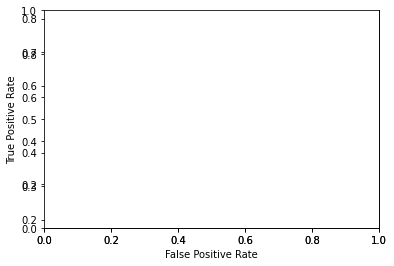

In [201]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn
#1: '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/cough_speech_models2/1/019--0.374--0.111.hdf5',
#2: '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/cough_speech_models2/2/018--0.602--0.094.hdf5',
#3: '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/cough_speech_models2/3/020--0.587--0.091.hdf5',
#4: '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/cough_speech_models2/4/017--0.409--0.128.hdf5'

# EDIT MODEL PATHS TO USE
models = {0: '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/cough_speech_breath_models/0/015--0.348--0.076---0.978.hdf5',
          1: '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/cough_speech_breath_models/1/020--0.257--0.037---0.997.hdf5',
          2: '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/cough_speech_breath_models/2/019--0.371--0.056---0.992.hdf5',
          3: '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/cough_speech_breath_models/3/019--0.256--0.039---0.996.hdf5',
          4: '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/cough_speech_breath_models/4/019--0.339--0.055---0.987.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(5):
  print(iii)

  test_features= DATA[iii]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[iii]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[iii]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[iii]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  TEST          = SevenInputGenerator(test_features,test_imgs,test_extra,test_imgsp,test_featuresp,test_imgsb,test_featuresb,test_labels,batch_size=48,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  #print(fpr)
  #print(tpr)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))
  print('recall: ', sklearn.metrics.recall_score(test_labels[:len(y_score)], y_score>0.5))
  print('recall: ', sklearn.metrics.precision_score(test_labels[:len(y_score)], y_score>0.5))
  print('auc: ', sklearn.metrics.roc_auc_score(test_labels[:len(y_score)], y_score>0.5))
  print('kapps: ', sklearn.metrics.cohen_kappa_score(test_labels[:len(y_score)], y_score>0.5))
  print(sklearn.metrics.classification_report(test_labels[:len(y_score)], y_score>0.5))
  print(sklearn.metrics.confusion_matrix(test_labels[:len(y_score)], y_score>0.5))  
  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
print(tprs)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

In [164]:
from keras.models import load_model
model = keras.models.load_model('/home/sumukhmlohit/my_project_dir/virufy-covid/cough/cough_speech_models/2/011--0.229--0.226.hdf5')
y_score = model.predict(TEST)
fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
print('Num_samples:', len(y_score))
print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))


Num_samples: 240
acc:  0.925


In [155]:
import librosa.display

In [4]:
def feature_extractor1(row):

  name     = row[0]
  try:
    audio,sr = librosa.load(row[1])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=39)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    plt.axis('off') # no axis
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpath,name+'.png')
    plt.savefig(savepath, bbox_inches=None, pad_inches=0)
    plt.close()
  except:
    print('File cannot open')
    return None,None
  return mfccsscaled,savepath

features = []
diagnoses= []
imgpaths = []

In [45]:
custpath='/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_input'
#row='/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200413/vK2bLRNzllXNeyOMudnNSL5cfpG2/breathing-shallow.wav'
#row='/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200820/TaoyZAahOzRoDQRxb0DtDZh8Opa2/cough-shallow.wav'
row=['IimA0GnOm7ZR4nEr8k0kG4eaR7A3','/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20201221/CUCqq4q5SQa3fDkpraekej7fNza2/cough-shallow.wav',0,1]

mfccs,savepath  = feature_extractor1(row)
features.append(mfccs)
imgpaths.append(savepath)
diagnoses.append([row[2],row[3]])

In [46]:
row

['IimA0GnOm7ZR4nEr8k0kG4eaR7A3',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20201221/CUCqq4q5SQa3fDkpraekej7fNza2/cough-shallow.wav',
 0,
 1]

In [29]:
cd '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200413/vK2bLRNzllXNeyOMudnNSL5cfpG2/'

/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200413/vK2bLRNzllXNeyOMudnNSL5cfpG2


In [41]:
cd '/home/sumukhmlohit/my_project_dir/virufy-covid/cough'

/home/sumukhmlohit/my_project_dir/virufy-covid/cough


In [42]:
ls

Coswara-Data/          count_covid.ipynb           model.h5
Untitled.ipynb         custom_dataset/             models/
Untitled1.ipynb        custom_dataset_breathing/   models1/
Untitled2.ipynb        custom_dataset_count_fast/  predict_cough.ipynb
breathing_covid.ipynb  custom_input/               public_dataset/
breathing_models/      fast_count_models/          public_dataset.zip
cough_model.ipynb      loaded_data.pickle          roc_curve.png
cough_model.py         loaded_data.pickle_count


In [47]:
tfeaturesd = np.array([mfccs for i in range(48)])
timgsd = np.array([savepath for i in range(48)])
textrad = np.array([[row[2],row[3]] for i in range(48)])
labelsd = np.array([1 for i in range(48)])

In [48]:
tfeaturesd.shape

(48, 39)

In [49]:
custom = TripleInputGenerator(tfeaturesd,timgsd,textrad,labelsd,batch_size=48,target_size=(64,64))

In [52]:
y_score1

array([[0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134]], dtype=float32)

In [51]:
y_score1=model.predict_generator(custom)
y_score1
x=y_score1>0.5

In [53]:
if x[0][0]==True:
    print('Positive')
else:
    print('Healthy')

Positive
